In [41]:
import lightkurve as lk
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Input, Concatenate, Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Metadata

## Načtení

In [42]:
pos = pd.read_csv("positive.csv")
pos

host  period
0    Kepler-1   2.470
1    Kepler-2   2.200
2    Kepler-3   4.890
3    Kepler-4   3.210
4    Kepler-5   3.580
5    Kepler-6   3.230
6    Kepler-7   4.890
7    Kepler-8   3.522
8   Kepler-11  32.000
9   Kepler-11  22.680
10  Kepler-11  13.020
11  Kepler-12   4.440
12  Kepler-13   1.760
13  Kepler-14   6.790
14  Kepler-15   4.940
15  Kepler-17   1.480
16  Kepler-18   7.650
17  Kepler-18  14.860
18  Kepler-19   9.290
19  Kepler-21   2.790
20  Kepler-23   7.100
21  Kepler-23  15.270
22  Kepler-27  15.330
23  Kepler-27  31.330
24  Kepler-28   5.910
25  Kepler-28   8.980

In [43]:
neg = pd.read_csv("negative.csv")
neg

host
0  KIC 10000785
1  KIC 10000797
2  KIC 10000800
3  KIC 10000823
4  KIC 10000827
5  KIC 10000876
6  KIC 10000939
7  KIC 10000941
8  KIC 10000962
9  KIC 10000976

## Seskupení dle systémů

In [44]:
grouped_pos = pos.groupby("host").period.apply(list).to_dict()
grouped_pos

{'Kepler-1': [2.47],
 'Kepler-11': [32.0, 22.68, 13.02],
 'Kepler-12': [4.44],
 'Kepler-13': [1.76],
 'Kepler-14': [6.79],
 'Kepler-15': [4.94],
 'Kepler-17': [1.48],
 'Kepler-18': [7.65, 14.86],
 'Kepler-19': [9.29],
 'Kepler-2': [2.2],
 'Kepler-21': [2.79],
 'Kepler-23': [7.1, 15.27],
 'Kepler-27': [15.33, 31.33],
 'Kepler-28': [5.91, 8.98],
 'Kepler-3': [4.89],
 'Kepler-4': [3.21],
 'Kepler-5': [3.58],
 'Kepler-6': [3.23],
 'Kepler-7': [4.89],
 'Kepler-8': [3.522]}

## Doplnění negativních period

In [46]:
grouped = []

for host in grouped_pos:
    periods = grouped_pos[host]
    
    grouped_item = {"host": host, "periods": []}

    for i in range(len(periods)):
        next = periods[i]
        current = {"period": round(next, 3), "planet": 1}

        if i > 0:
            last = periods[i - 1]
            mid = max((next + last) / 2, 0.6 * 1.13)
            grouped_item["periods"] += [{"period": round(mid, 3), "planet": 0}, current]
        else:
            grouped_item["periods"] += [current]

    grouped_item["periods"] += [{"period": round(periods[-1] * 1.67, 3), "planet": 0}]
    grouped.append(grouped_item)

for i, row in neg.iterrows():
    per = lambda per: { "period": per, "planet": 0 }
    grouped.append({"host": row["host"], "periods": [per(1), per(6), per(36), per(85)] })

n_views = sum([len(host["periods"]) for host in grouped])

grouped, n_views

([{'host': 'Kepler-1',
   'periods': [{'period': 2.47, 'planet': 1}, {'period': 4.125, 'planet': 0}]},
  {'host': 'Kepler-11',
   'periods': [{'period': 32.0, 'planet': 1},
    {'period': 27.34, 'planet': 0},
    {'period': 22.68, 'planet': 1},
    {'period': 17.85, 'planet': 0},
    {'period': 13.02, 'planet': 1},
    {'period': 21.743, 'planet': 0}]},
  {'host': 'Kepler-12',
   'periods': [{'period': 4.44, 'planet': 1}, {'period': 7.415, 'planet': 0}]},
  {'host': 'Kepler-13',
   'periods': [{'period': 1.76, 'planet': 1}, {'period': 2.939, 'planet': 0}]},
  {'host': 'Kepler-14',
   'periods': [{'period': 6.79, 'planet': 1},
    {'period': 11.339, 'planet': 0}]},
  {'host': 'Kepler-15',
   'periods': [{'period': 4.94, 'planet': 1}, {'period': 8.25, 'planet': 0}]},
  {'host': 'Kepler-17',
   'periods': [{'period': 1.48, 'planet': 1}, {'period': 2.472, 'planet': 0}]},
  {'host': 'Kepler-18',
   'periods': [{'period': 7.65, 'planet': 1},
    {'period': 11.255, 'planet': 0},
    {'period'

# Trénovací množina

## Stažení TPS a uložení křivek

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

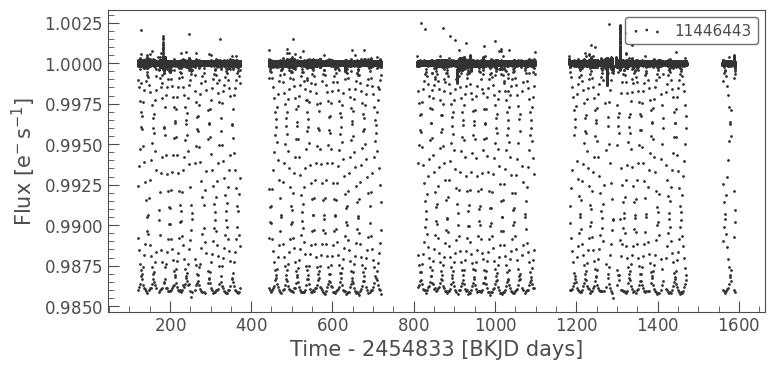

In [47]:
lcs = {}

for item in grouped:
    host, periods = item["host"], item["periods"]
    lc_path = f".cache/lc/{host}.fits"

    try:
        lc = lk.read(lc_path)
    except:
        result = lk.search_targetpixelfile(host, mission="Kepler", exptime="long")
        tps = result.download_all()
        lcc = map(lambda tp: tp.to_lightcurve(aperture_mask=tp.pipeline_mask).flatten(window_length=201), tps)
        lcc = lk.LightCurveCollection(lcc)
        lcc.plot()
        lc = lcc.stitch().remove_outliers(sigma_upper=3, sigma_lower=20)
        lc.to_fits(lc_path)

    lcs[host] = lc

lcs[list(lcs.keys())[0]].scatter()

## Hledání period a sestavení lokálních a globálních pohledů

`period` contains 175520 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
`period` contains 105099 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
`period` contains 246327 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
/home/michal/.local/lib/python3.8/site-packages/lightkurve/lightcurve.py:1772: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)
`period` contains 147511 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.
`period` contains 288573 points.Periodogram is l

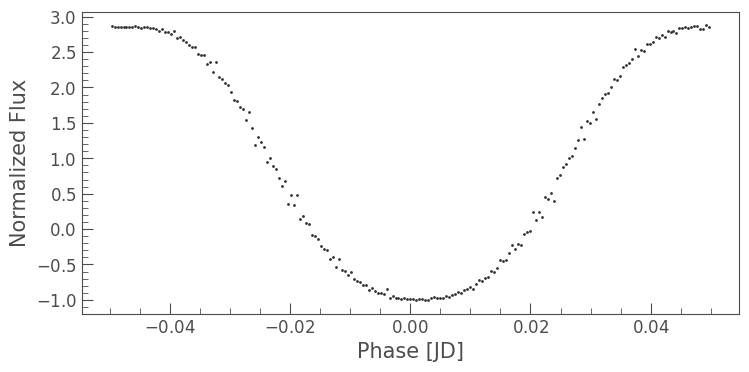

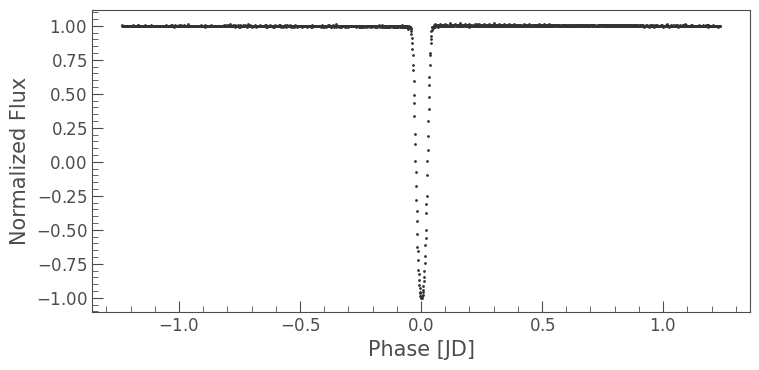

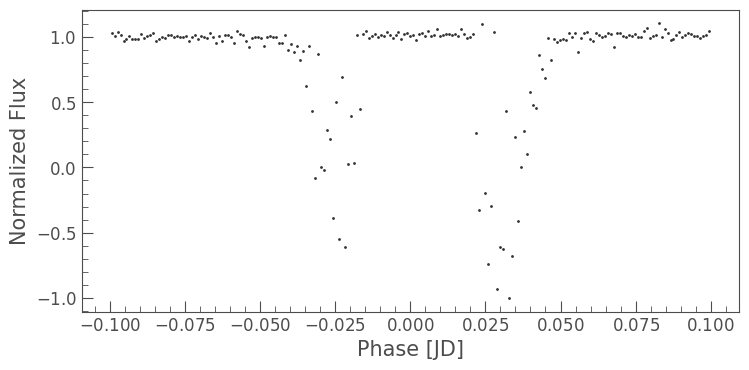

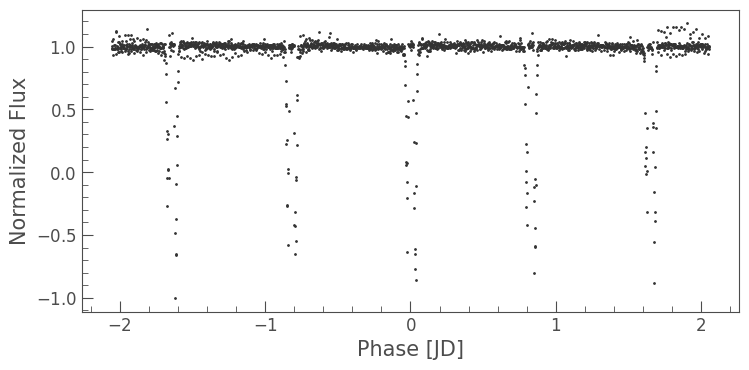

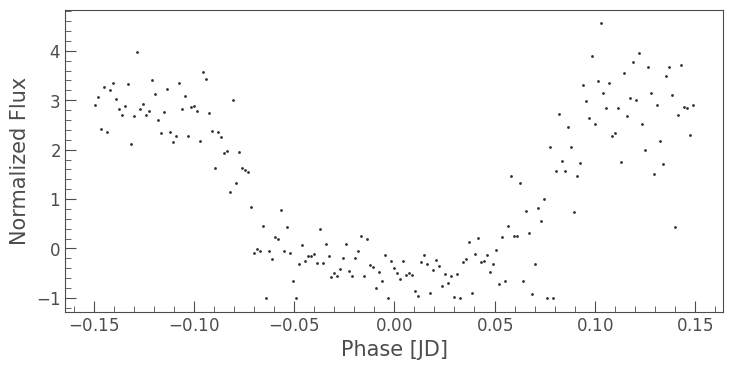

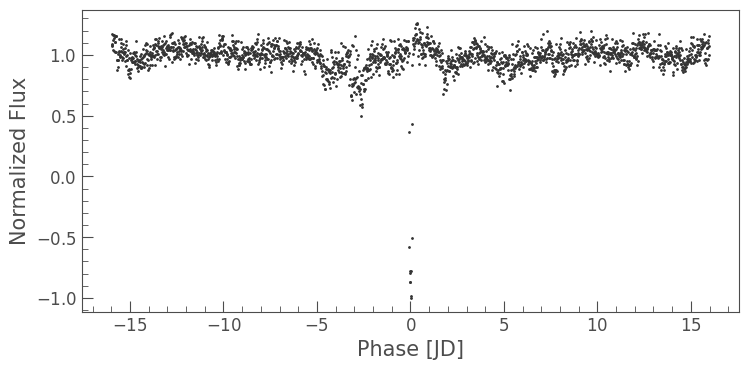

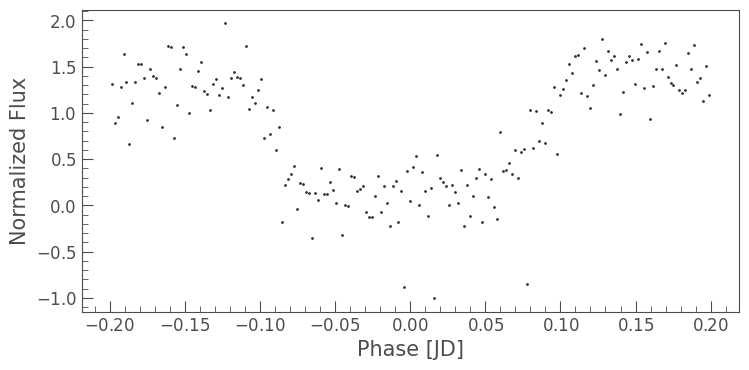

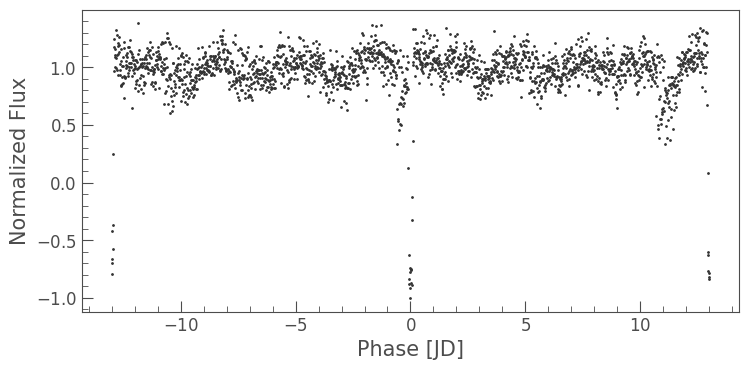

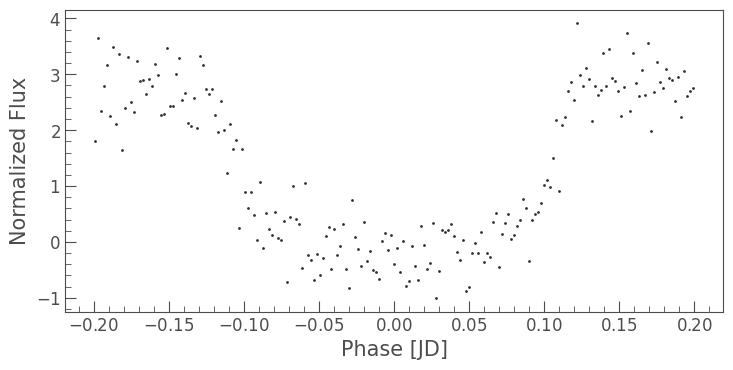

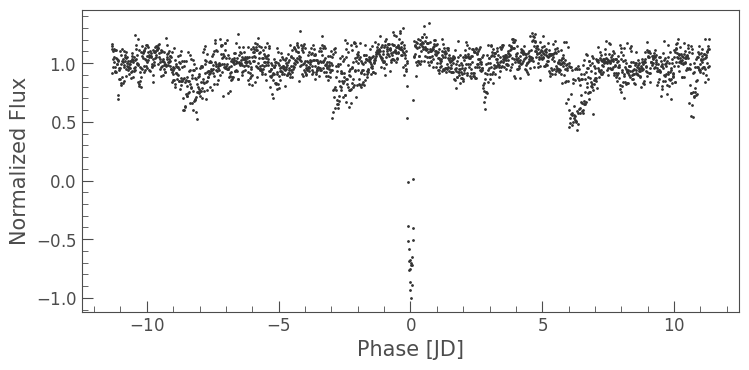

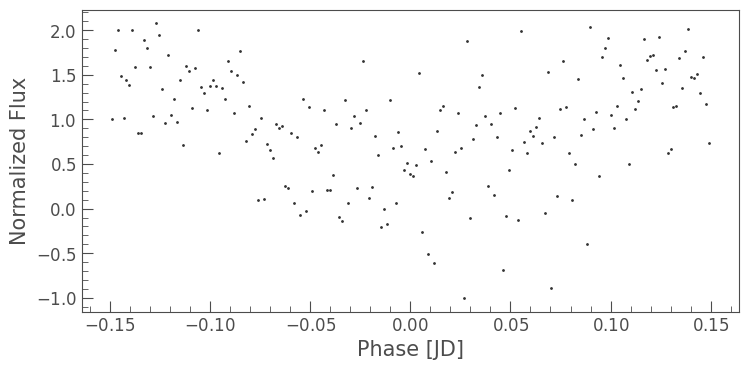

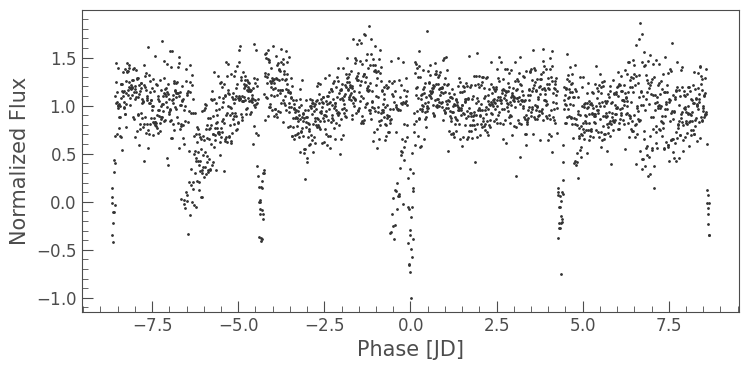

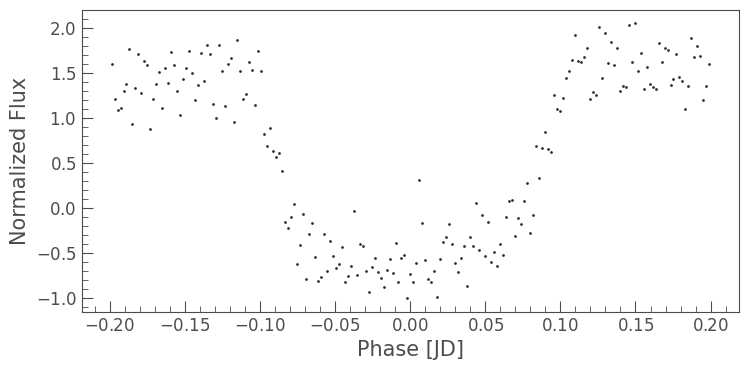

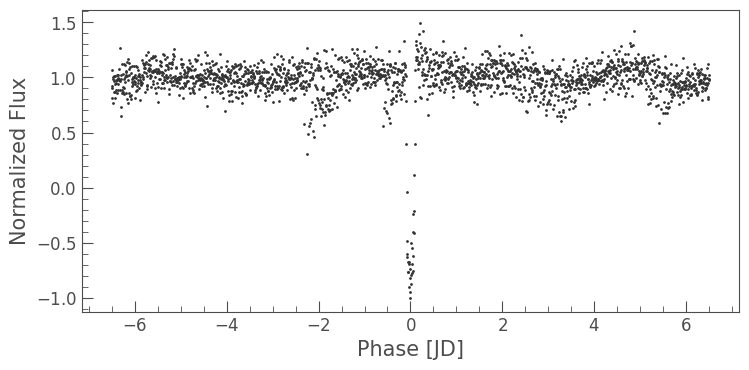

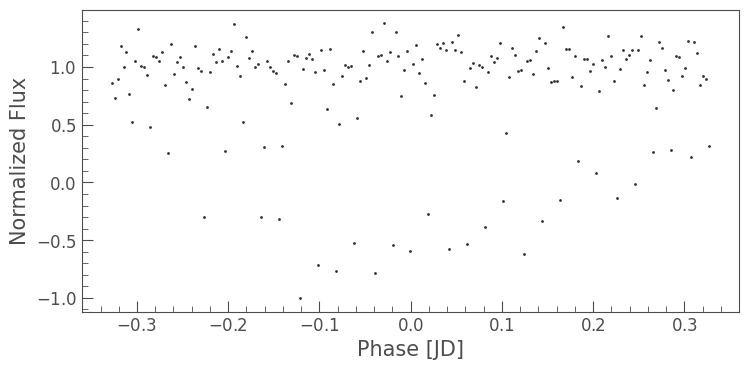

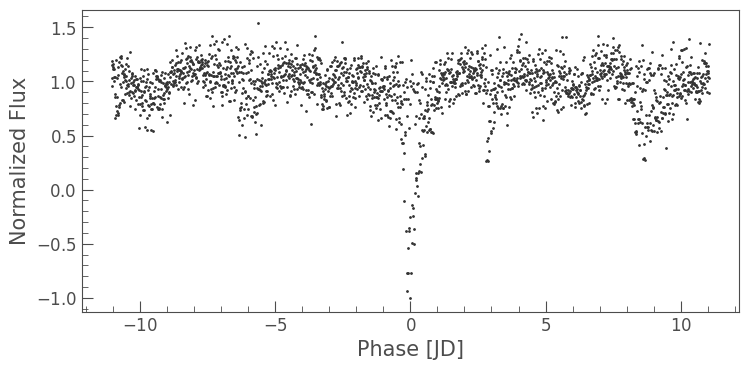

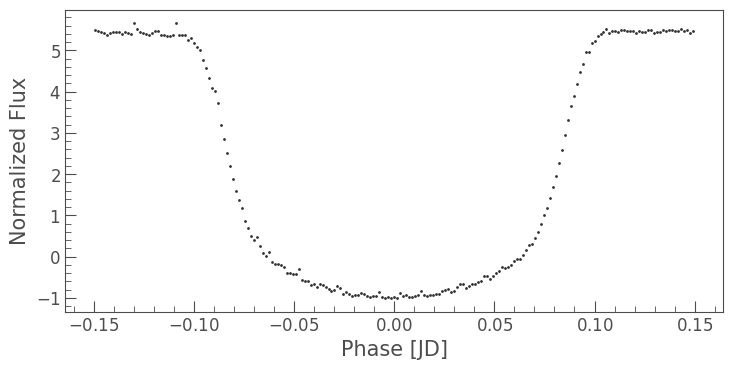

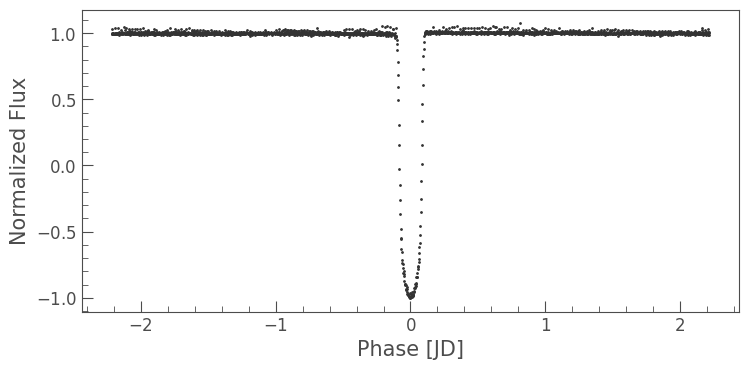

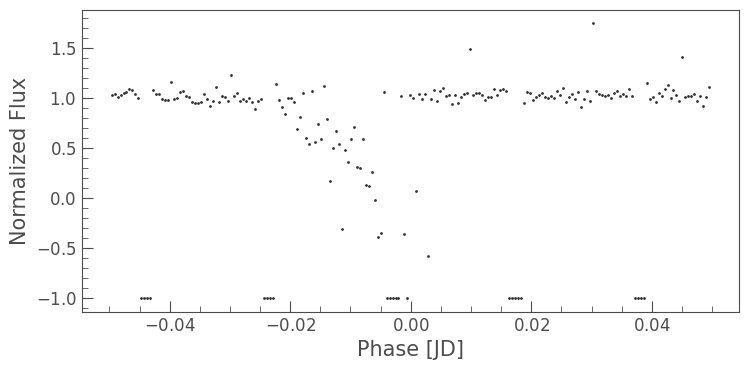

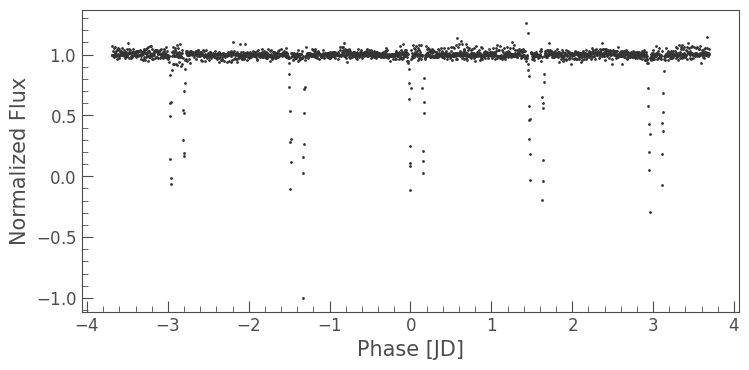

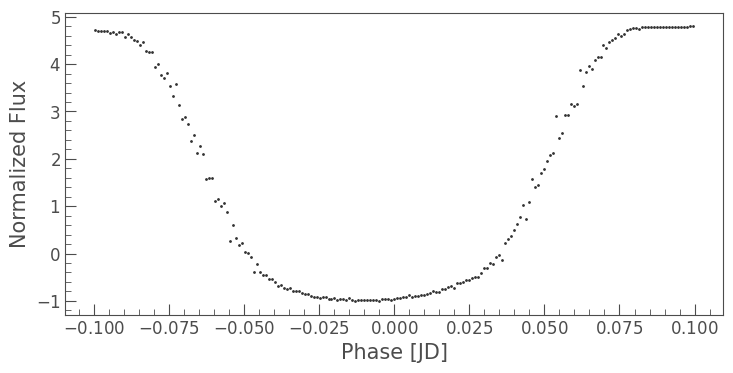

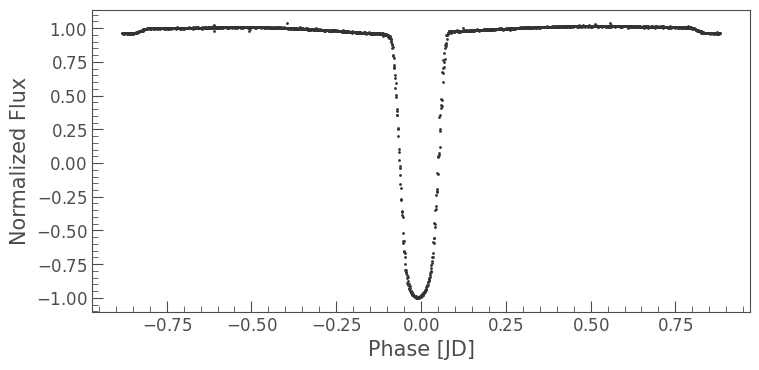

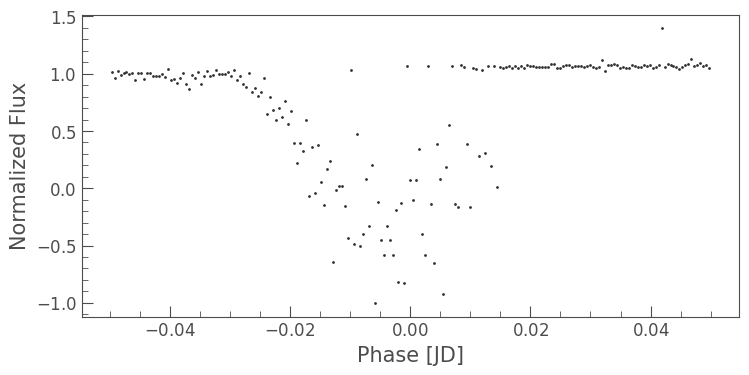

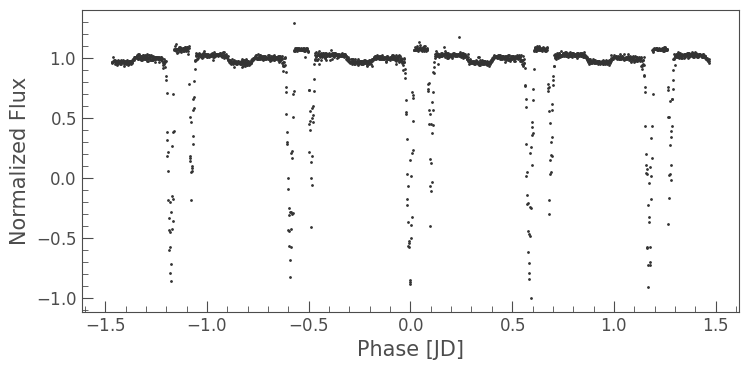

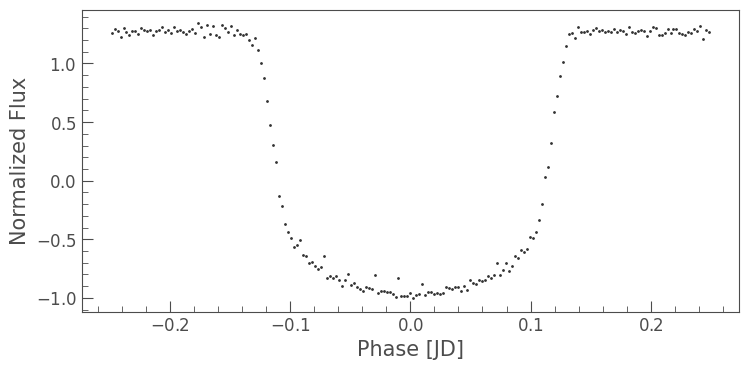

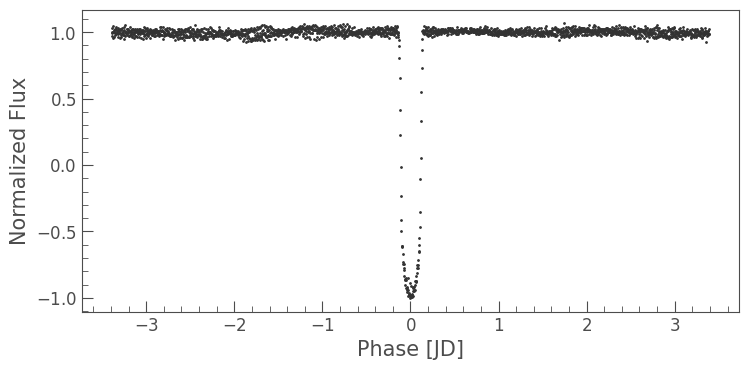

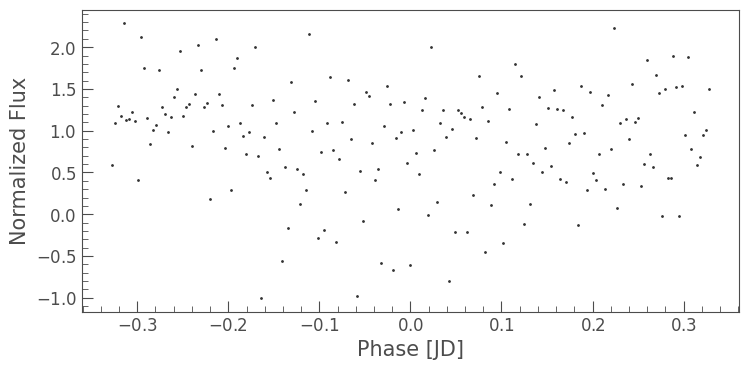

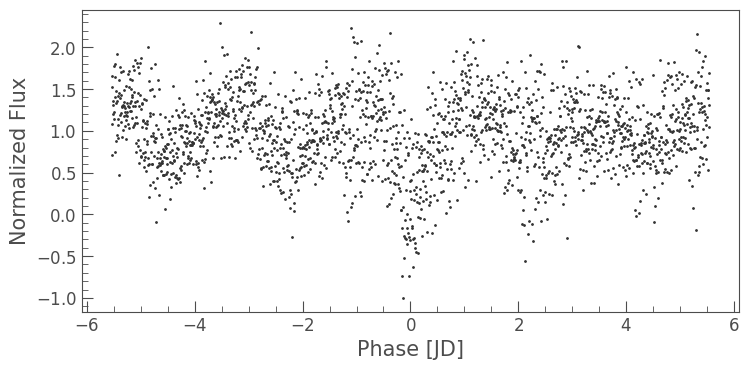

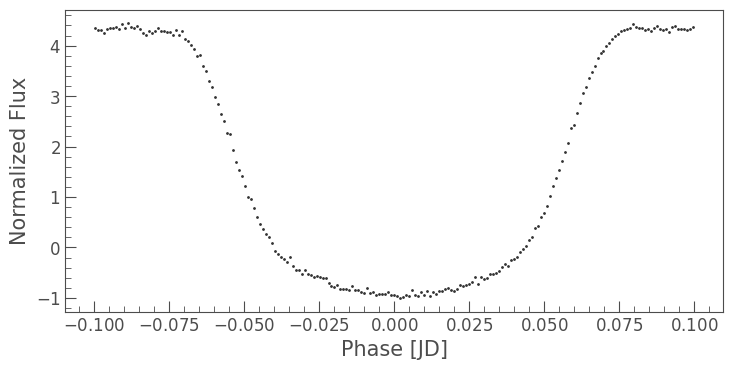

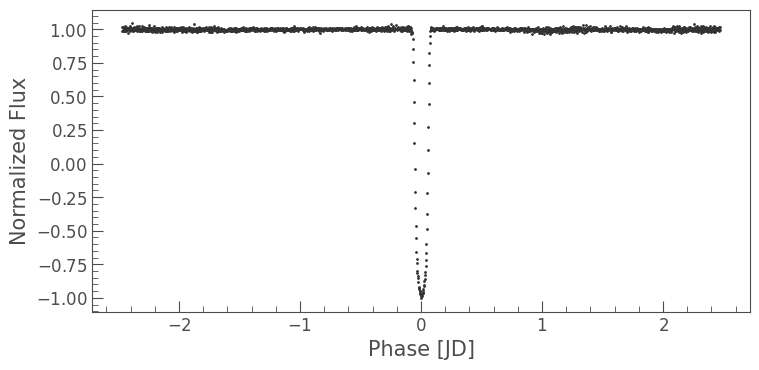

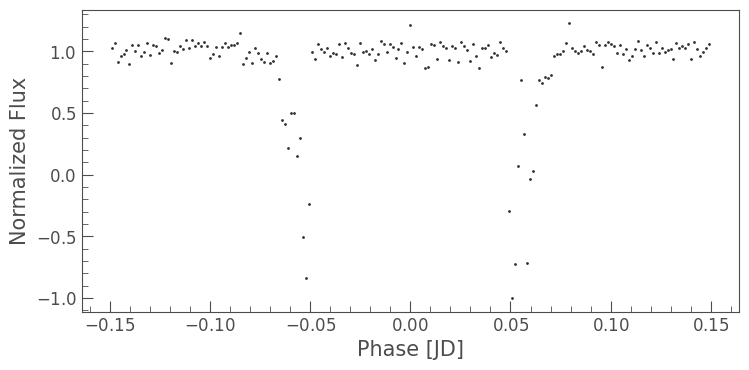

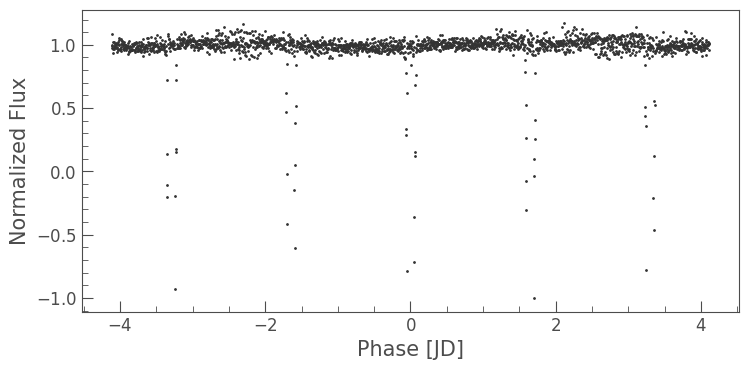

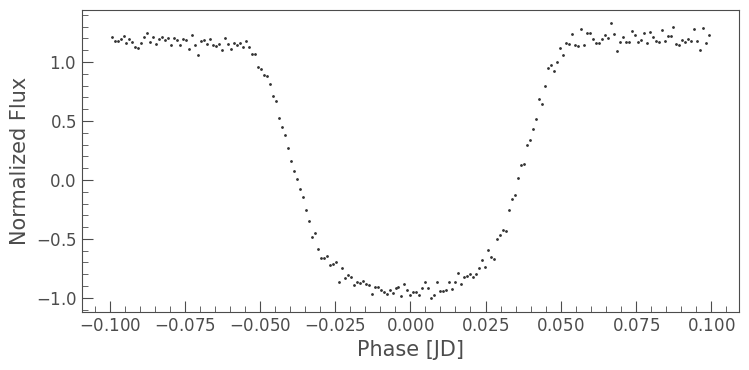

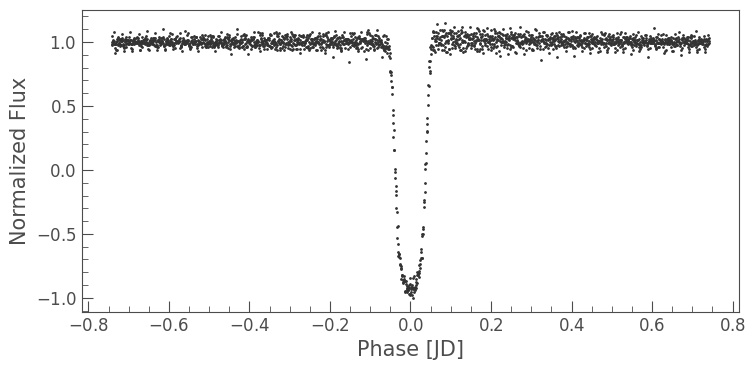

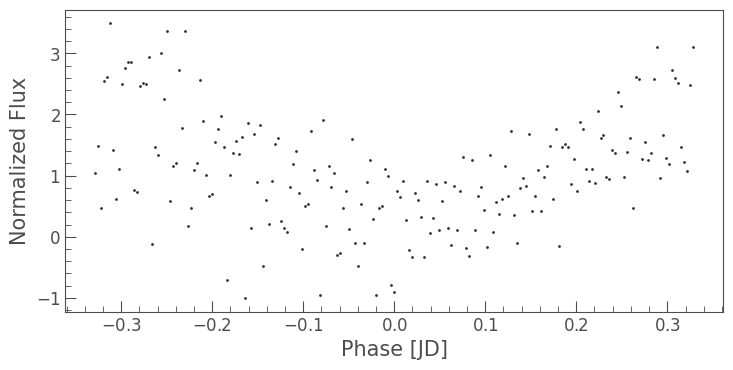

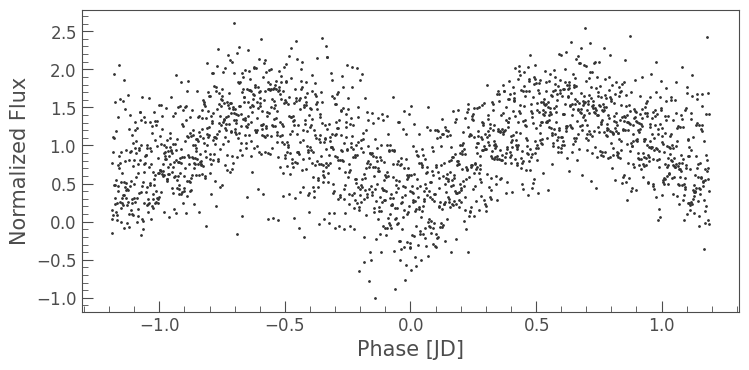

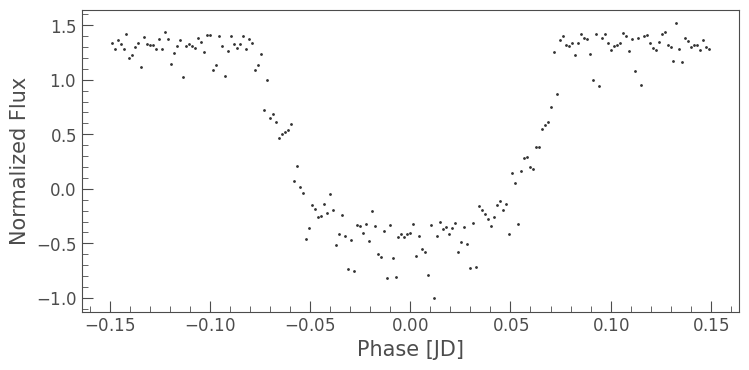

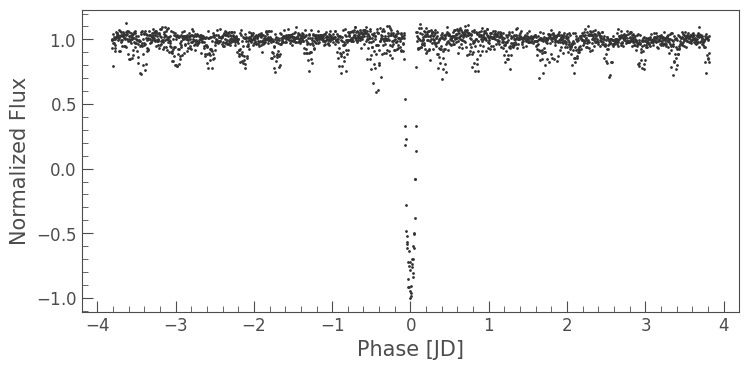

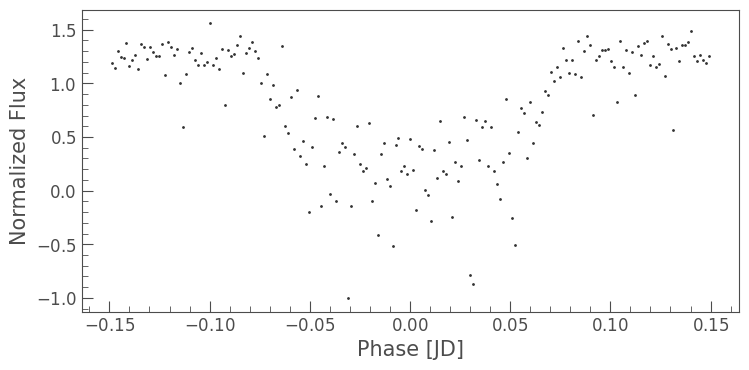

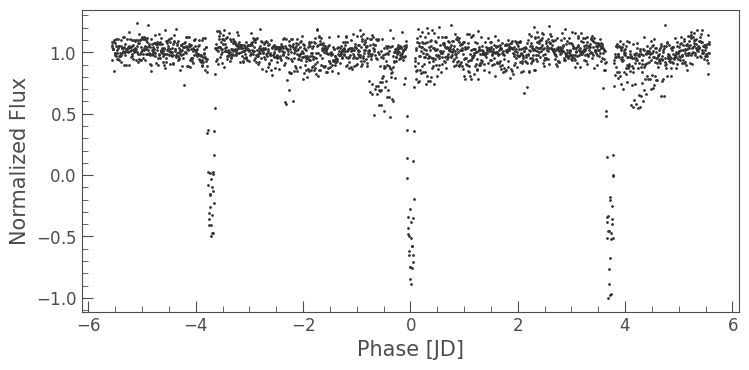

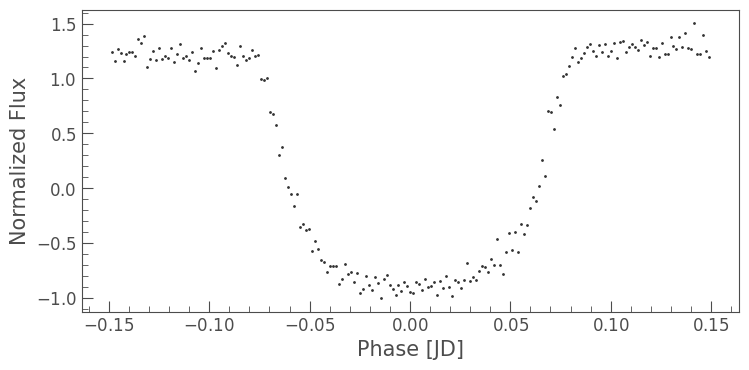

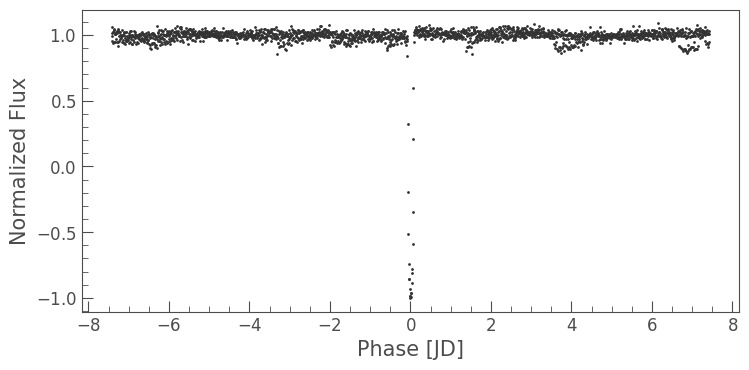

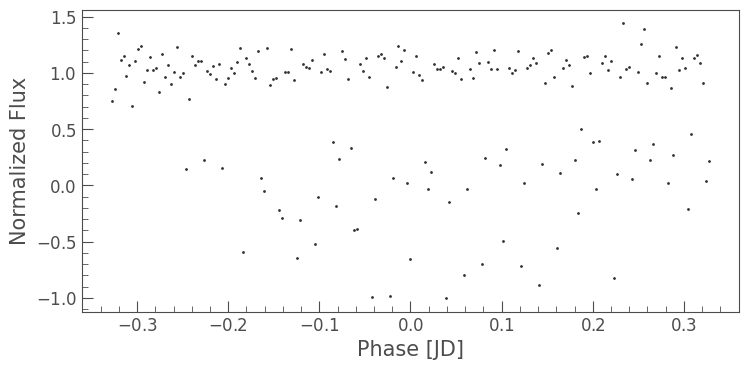

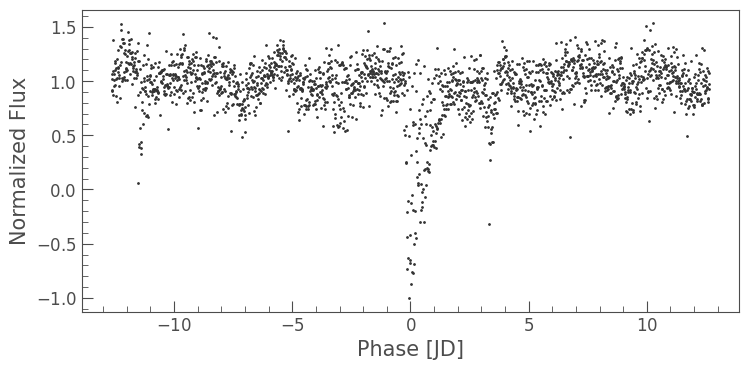

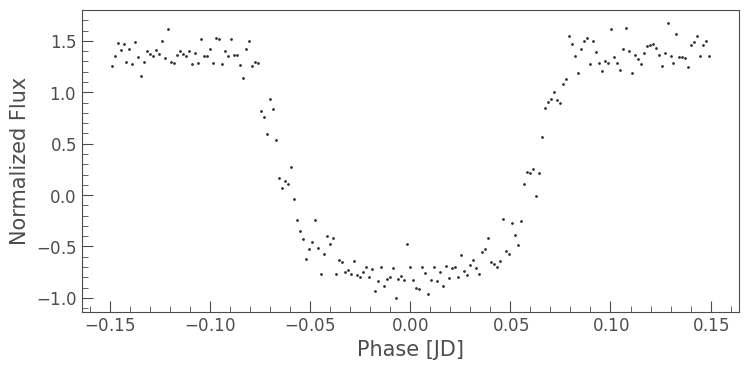

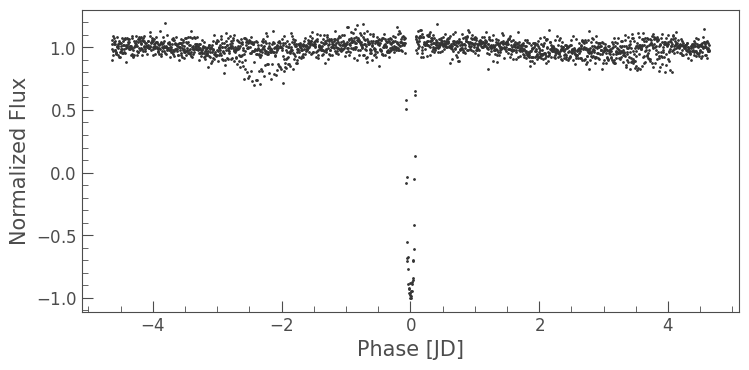

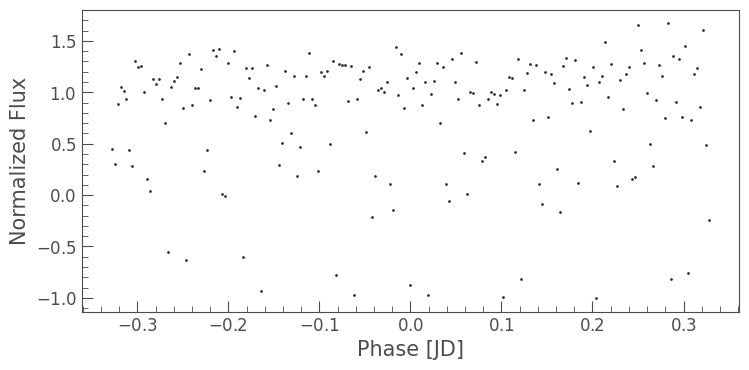

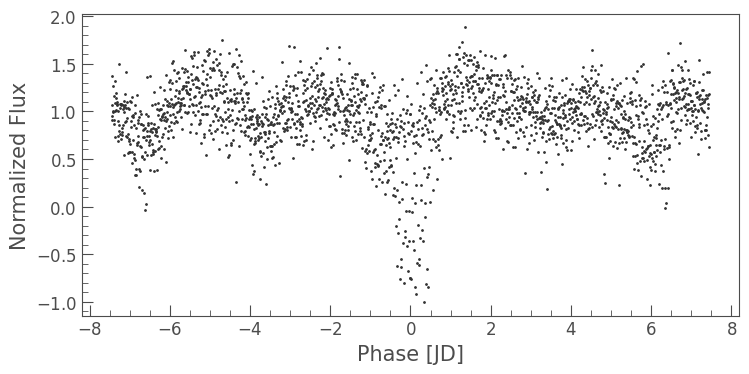

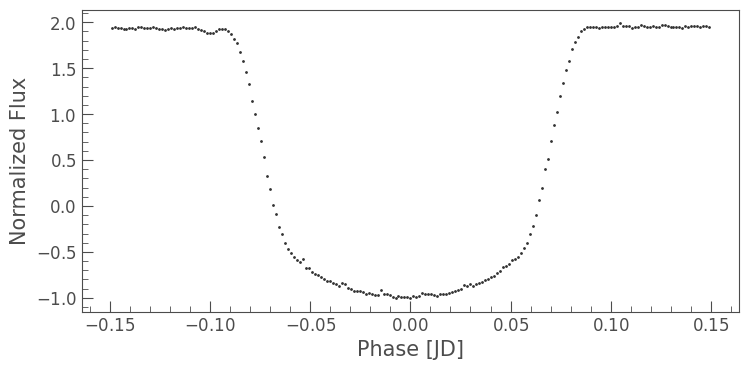

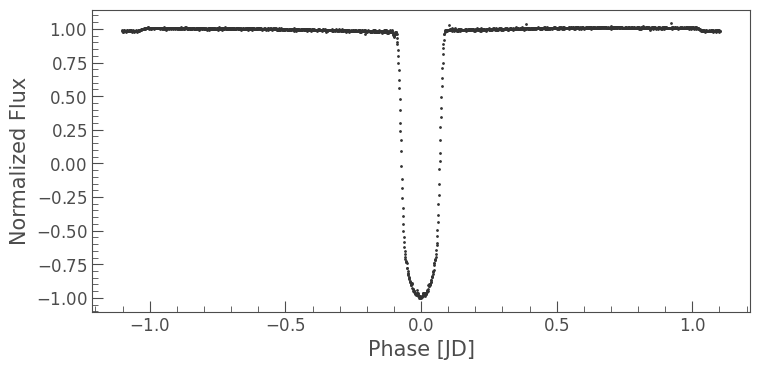

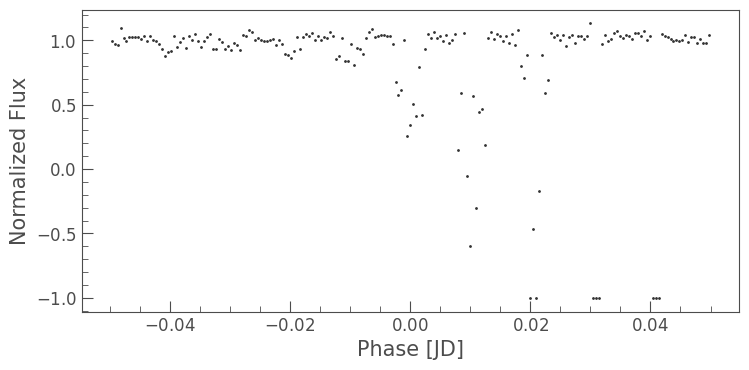

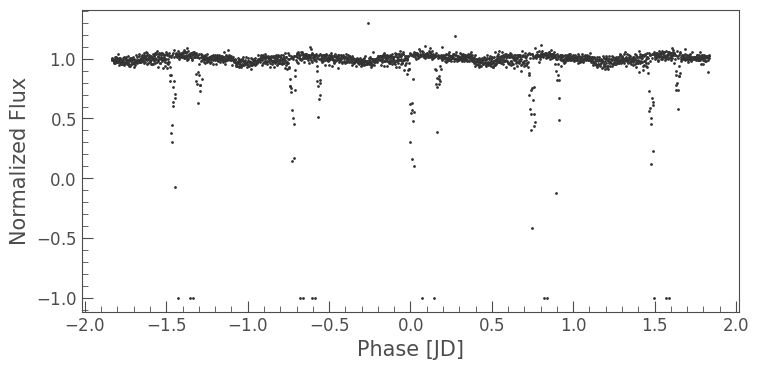

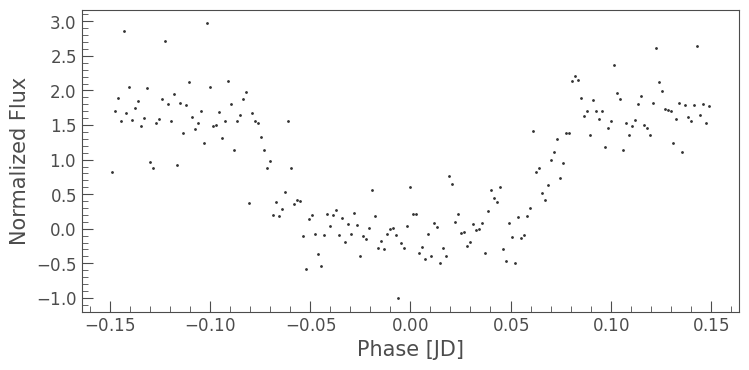

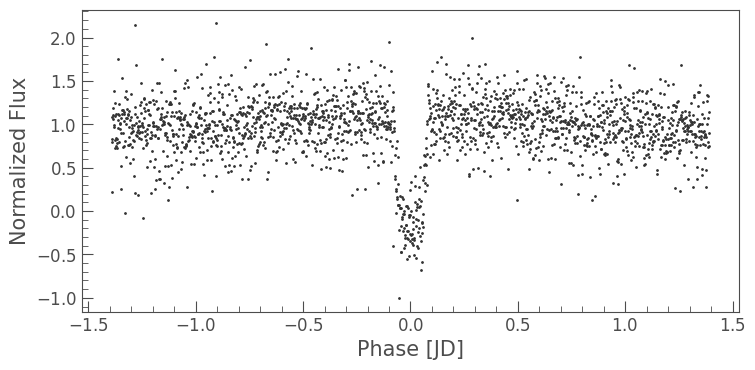

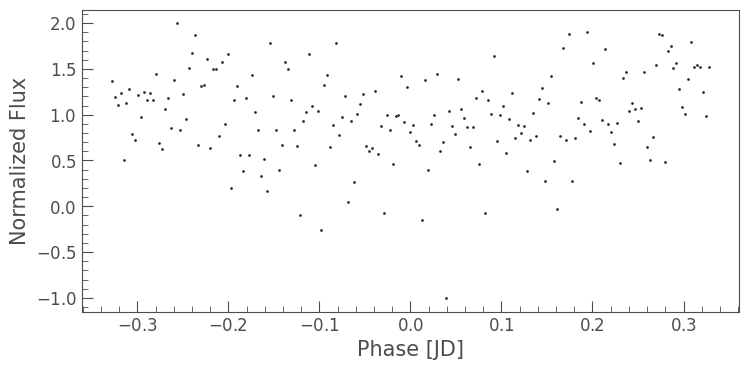

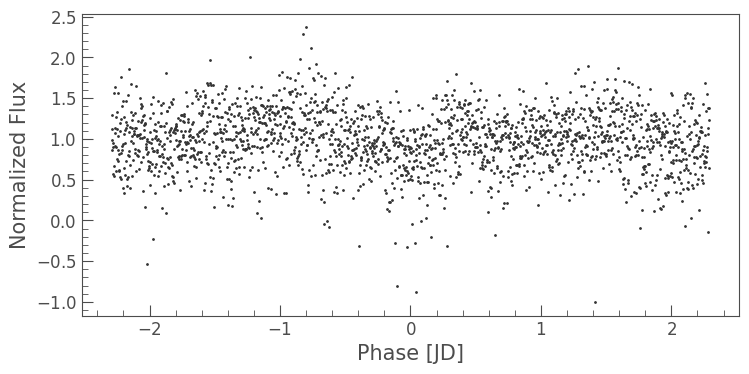

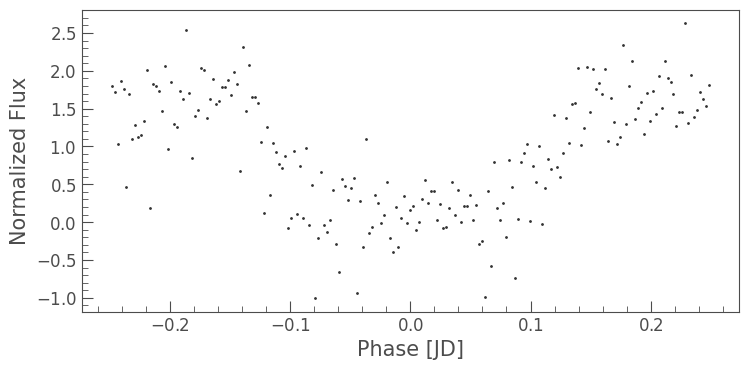

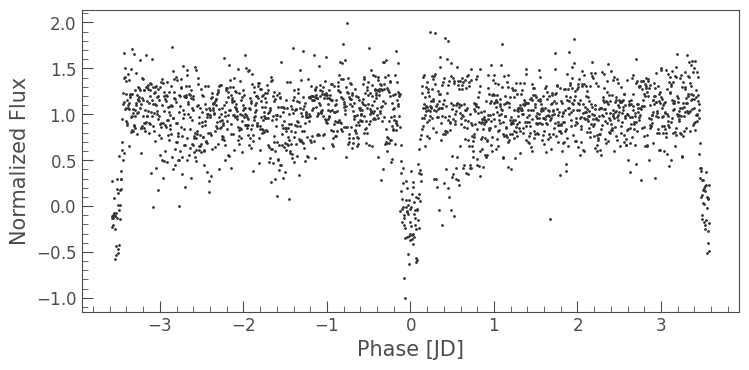

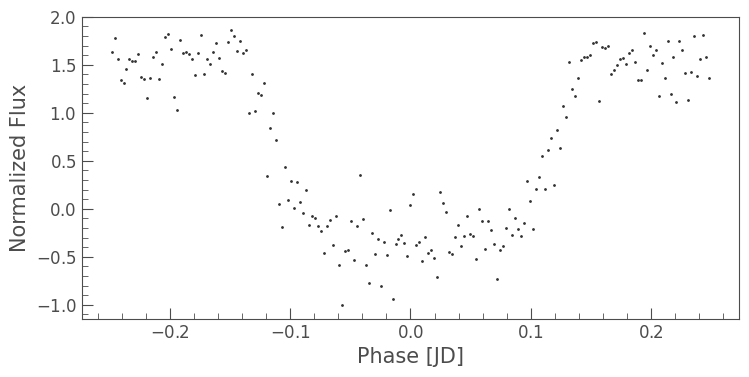

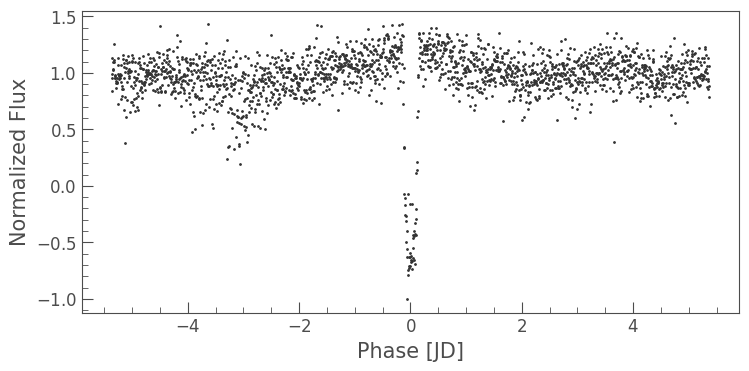

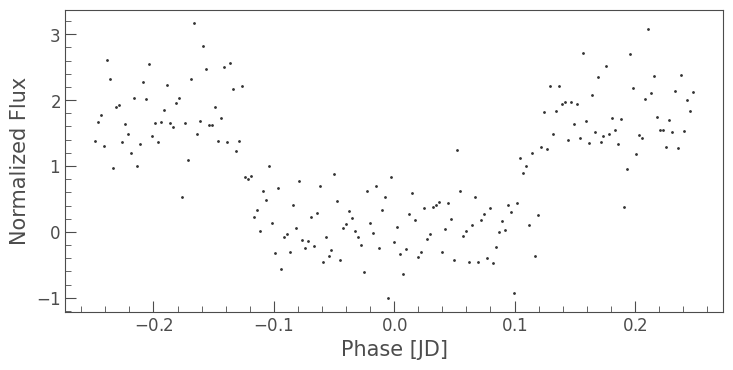

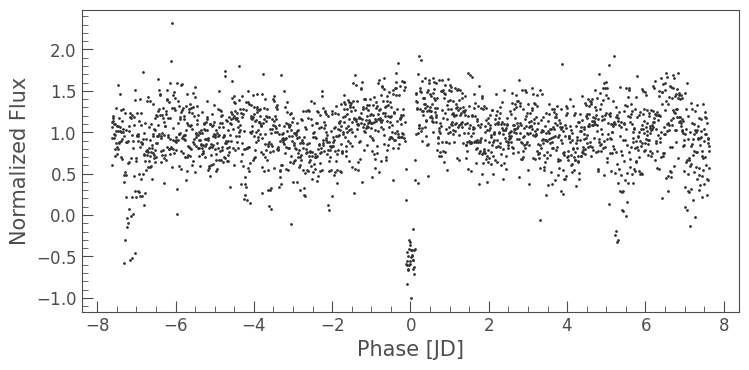

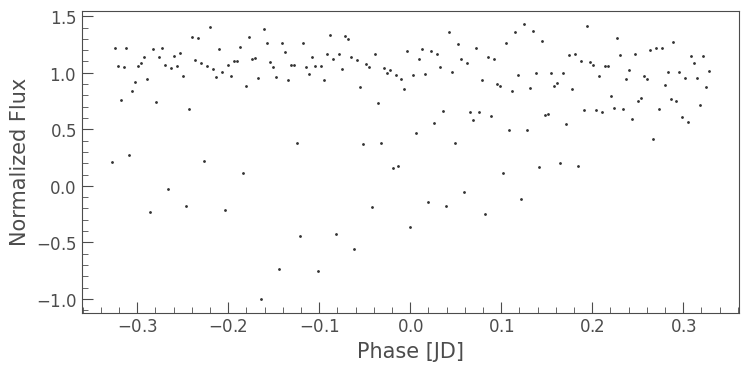

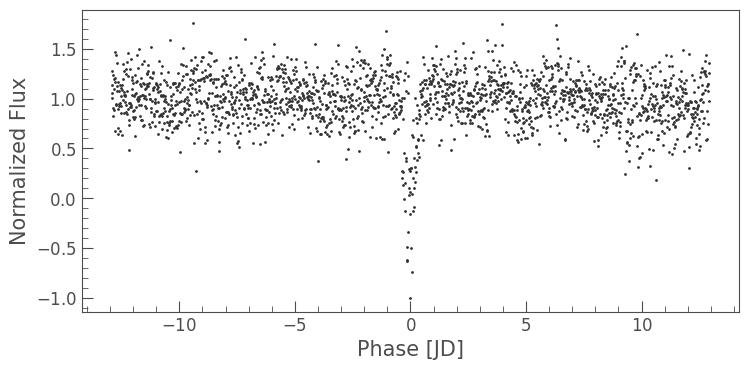

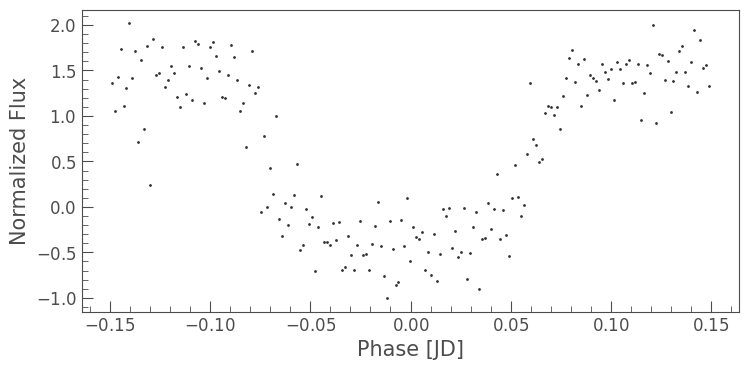

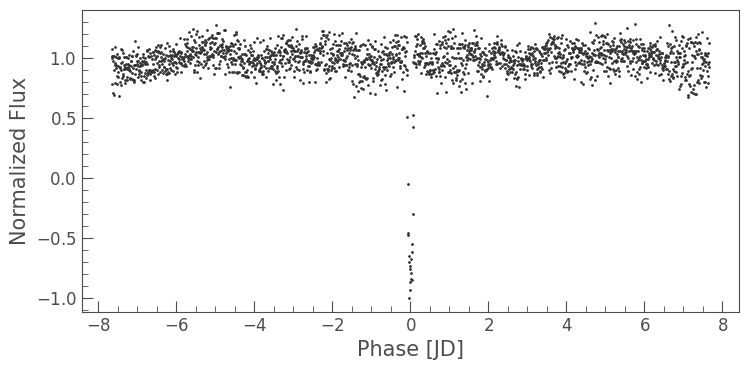

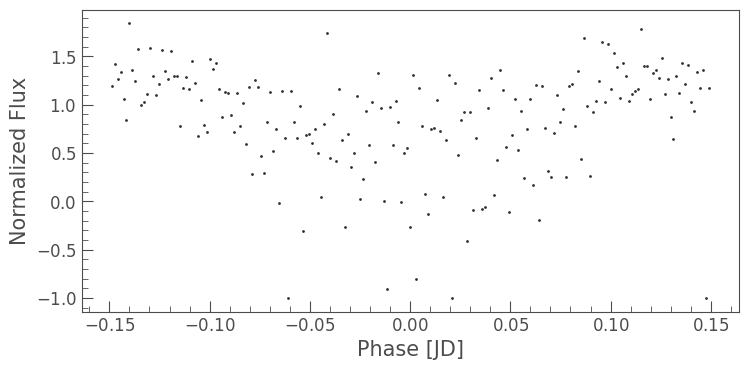

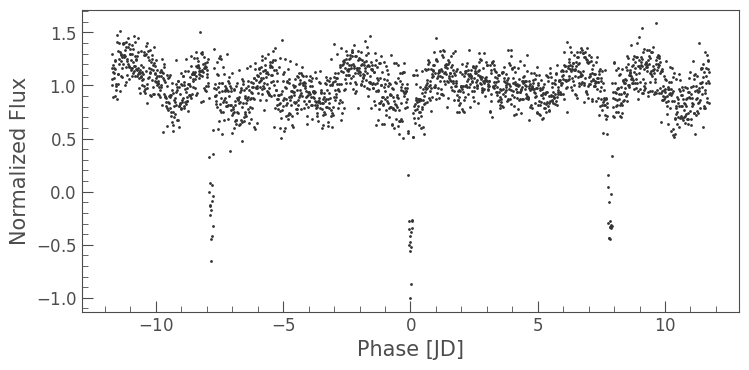

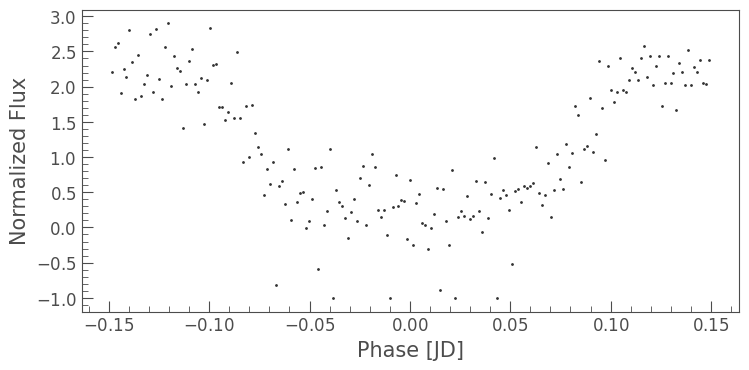

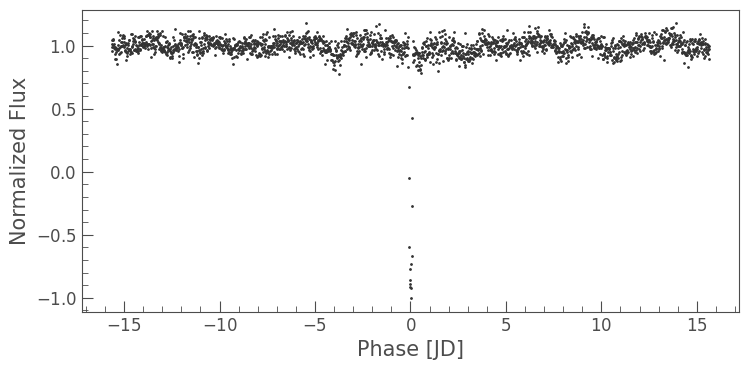

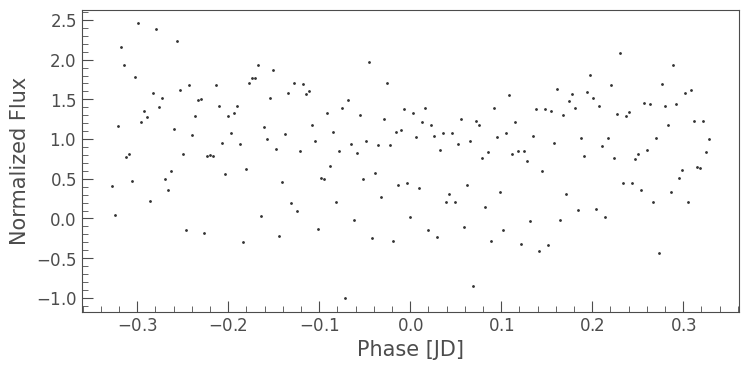

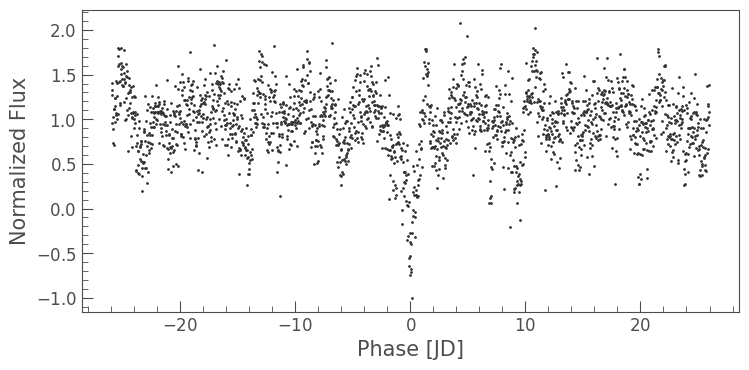

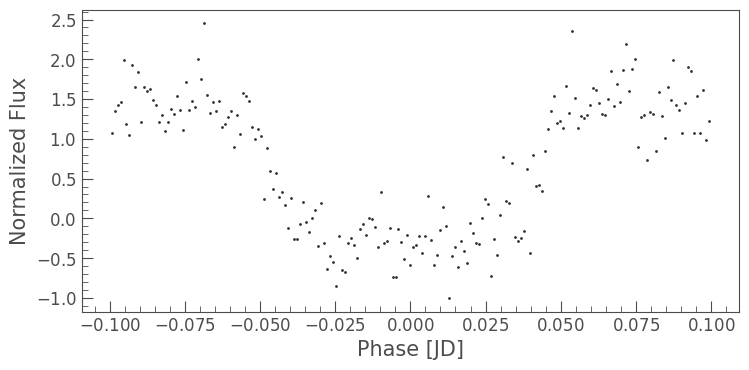

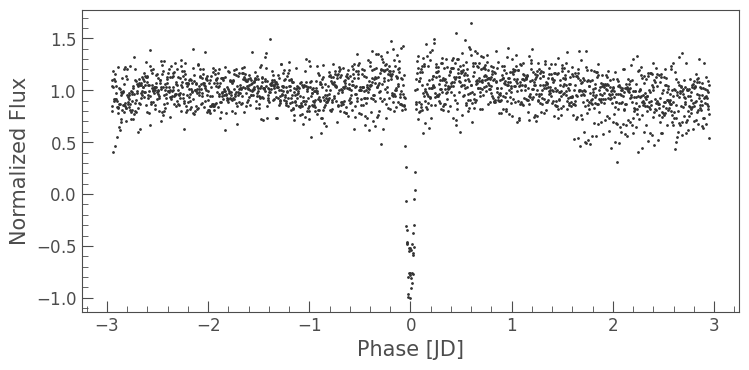

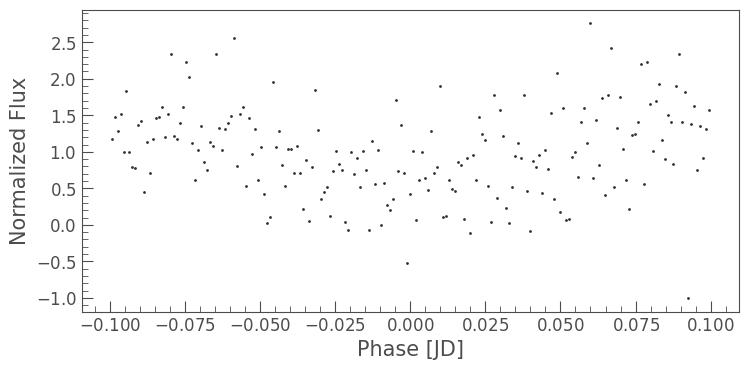

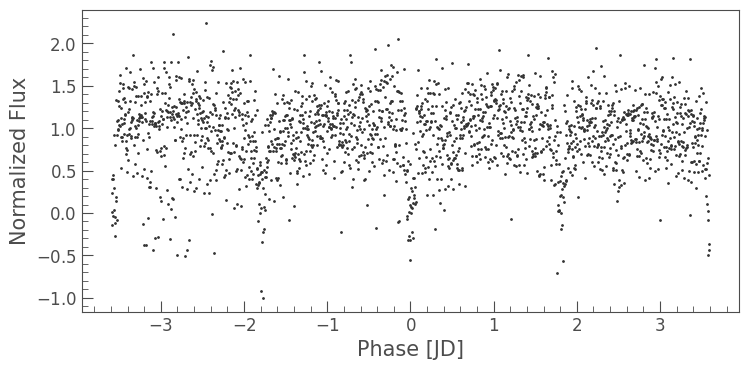

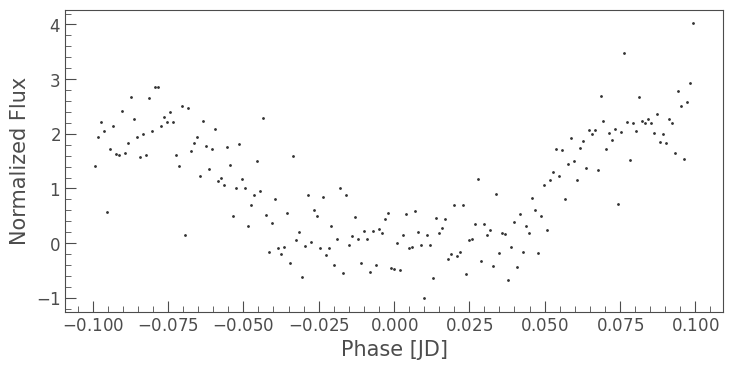

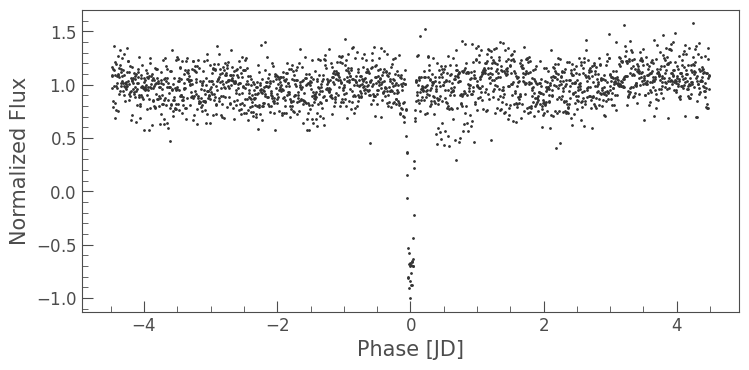

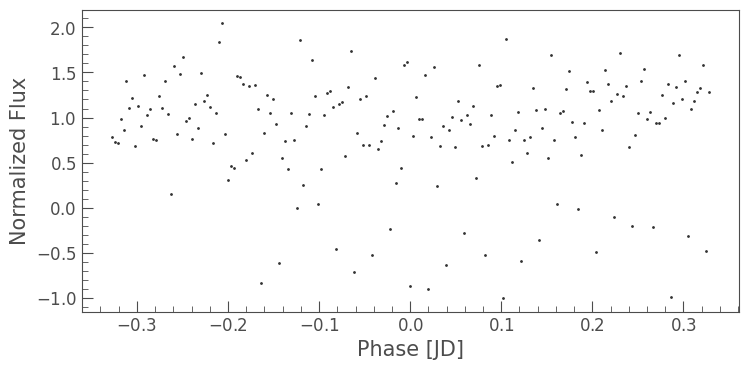

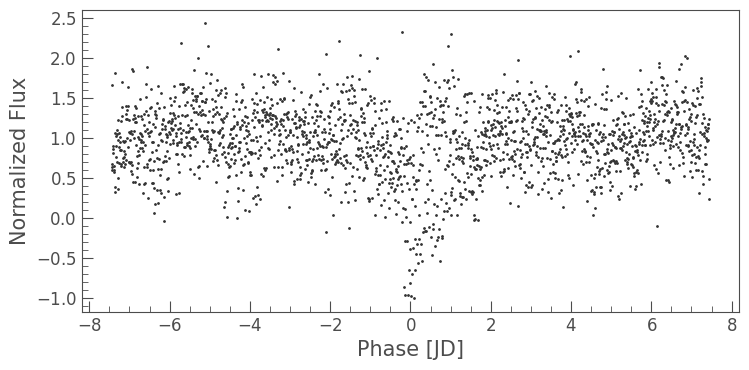

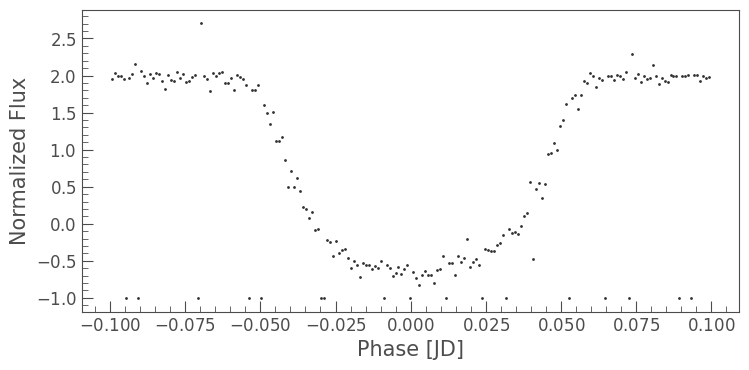

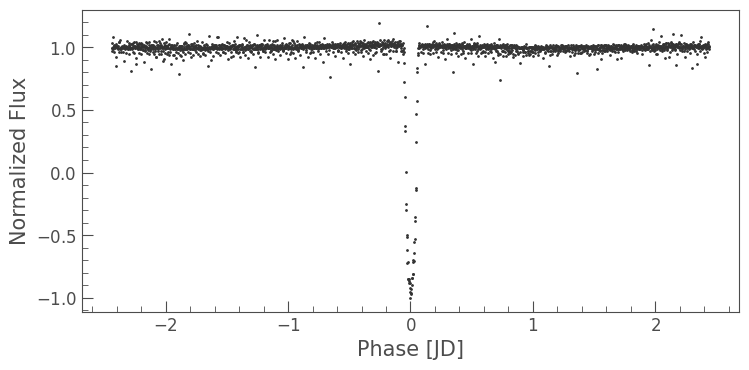

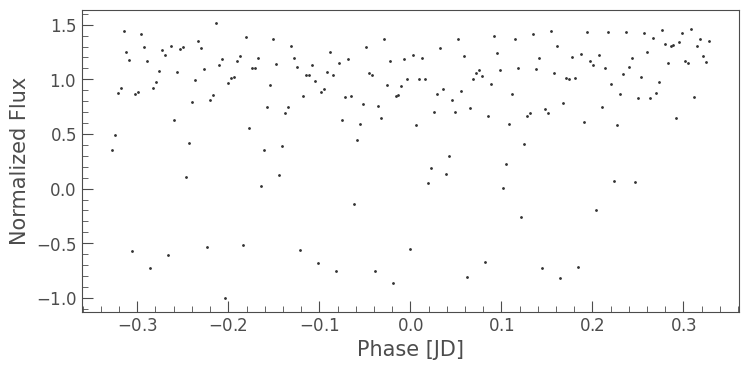

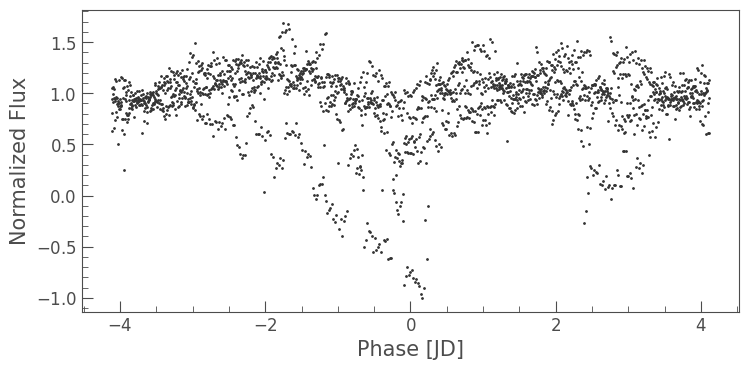

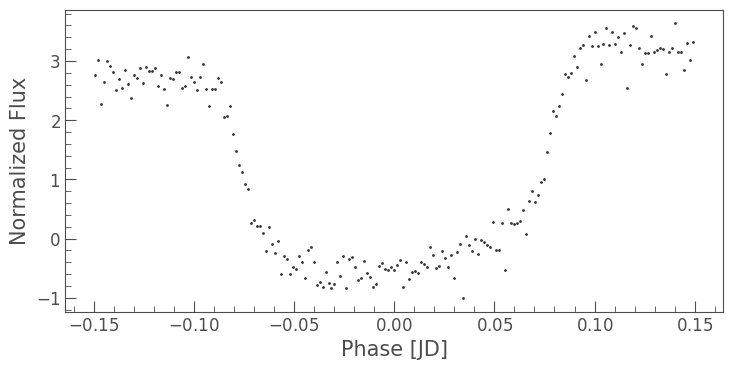

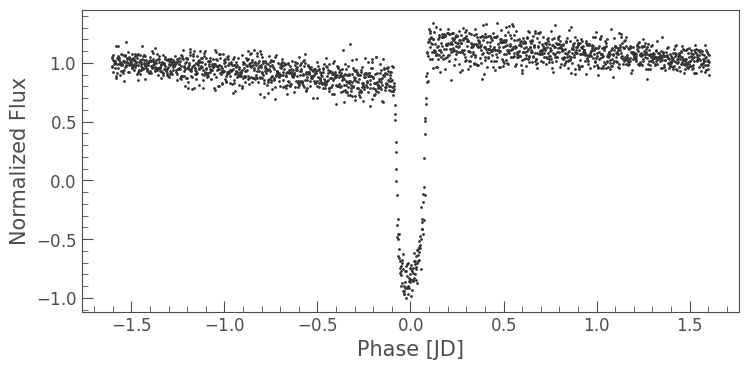

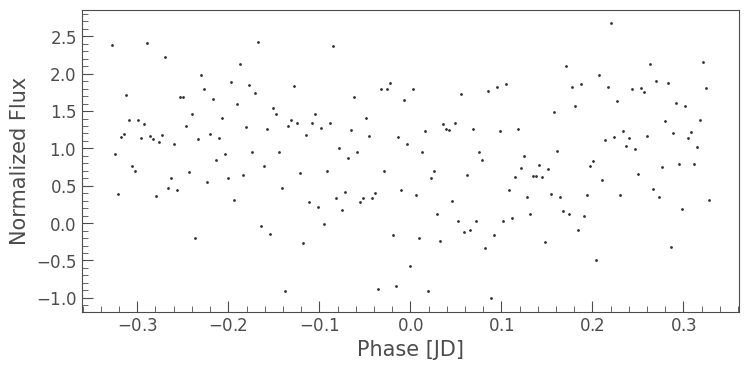

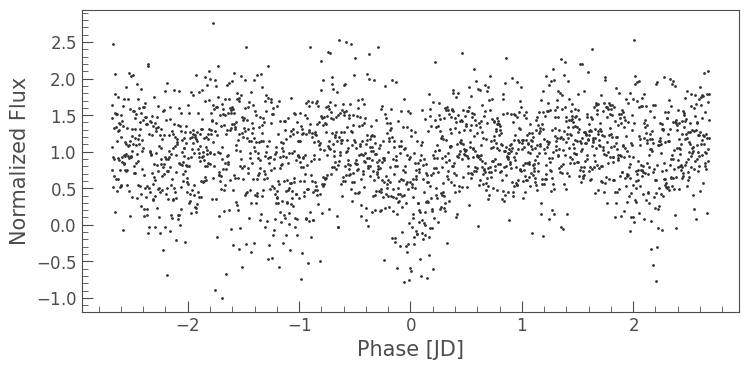

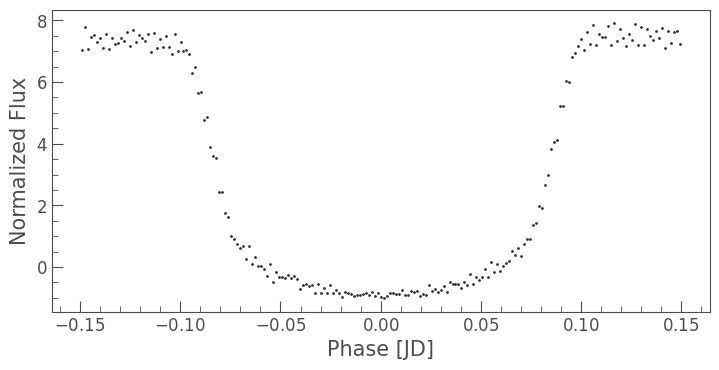

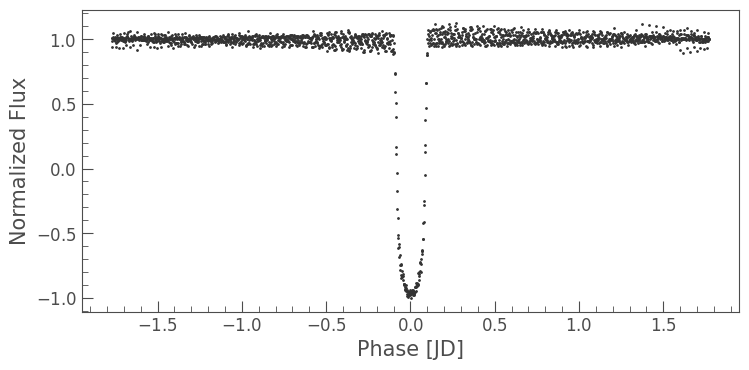

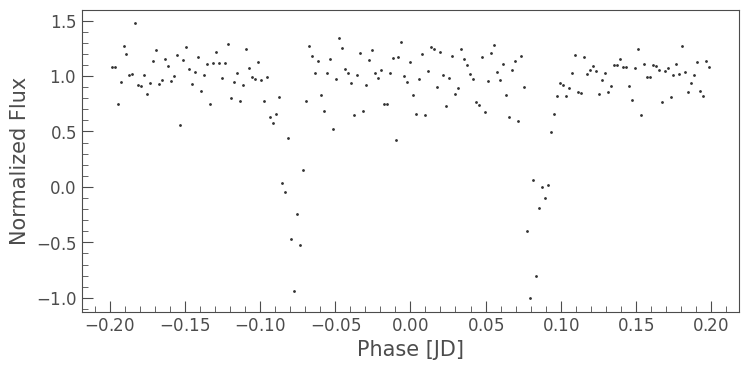

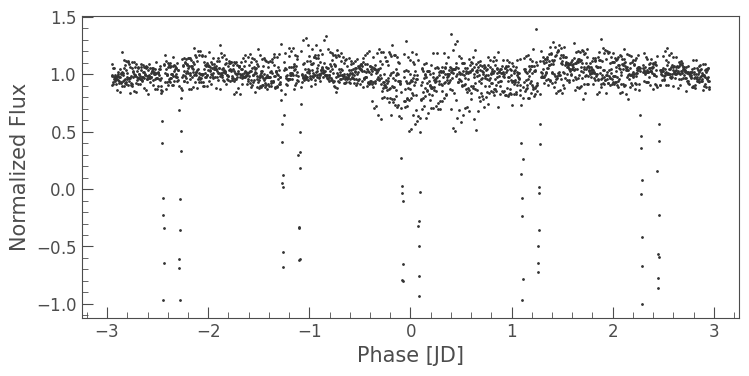

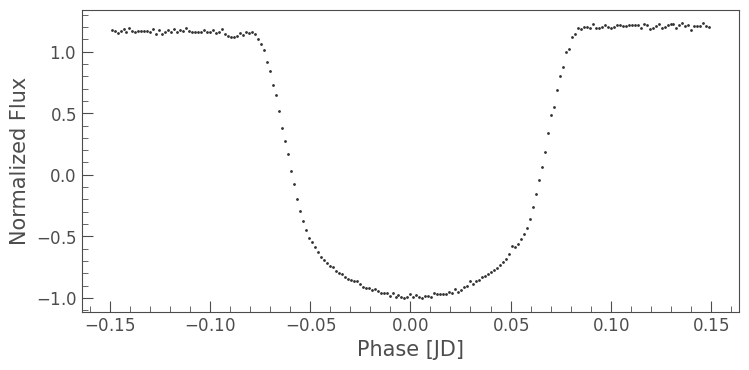

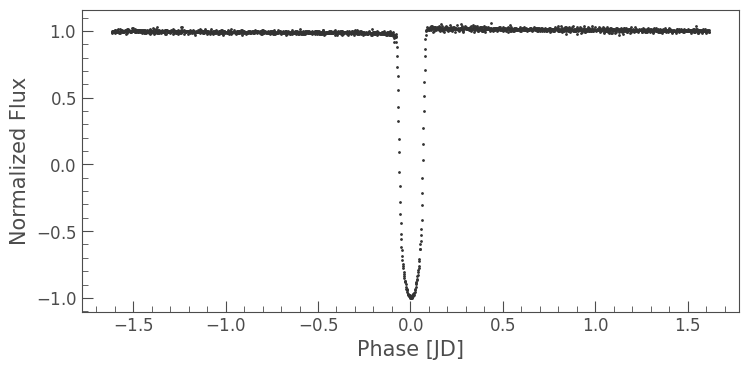

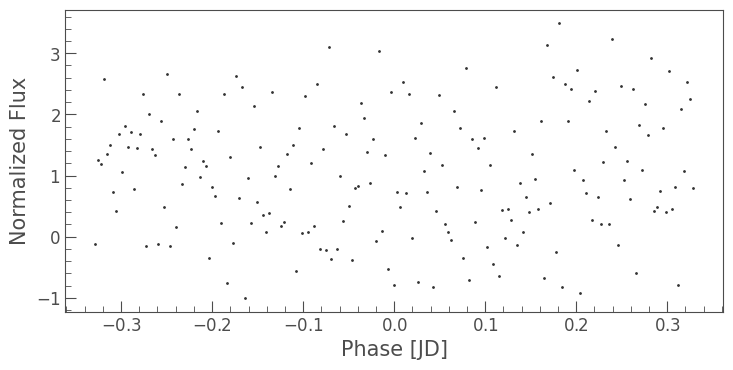

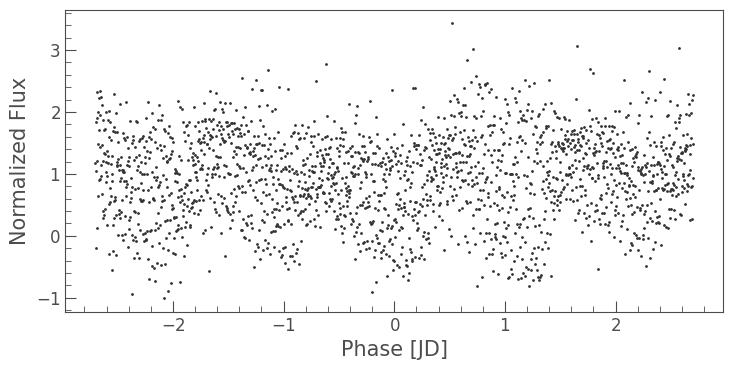

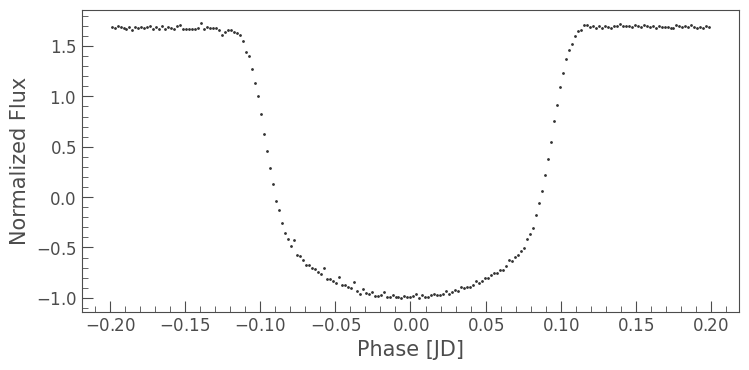

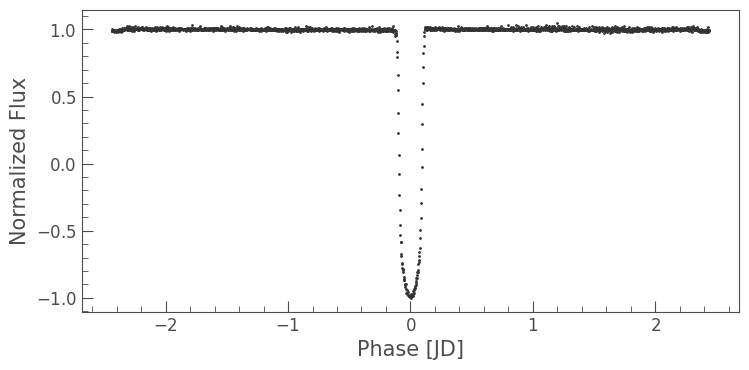

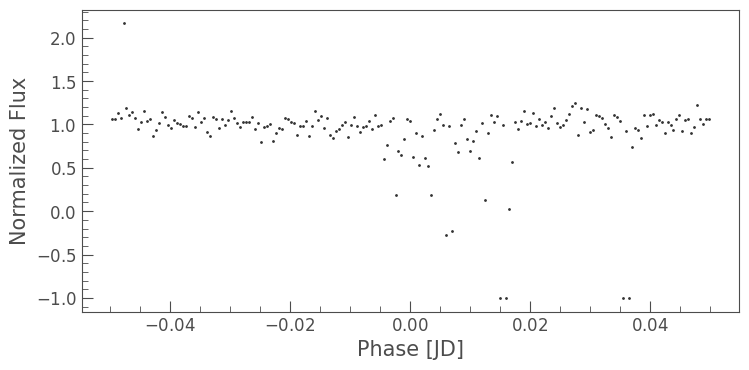

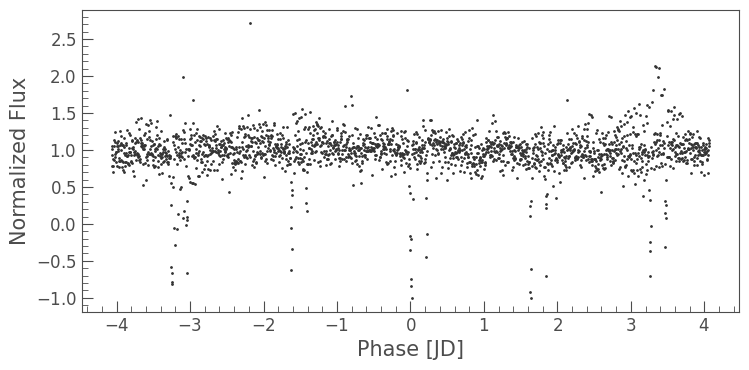

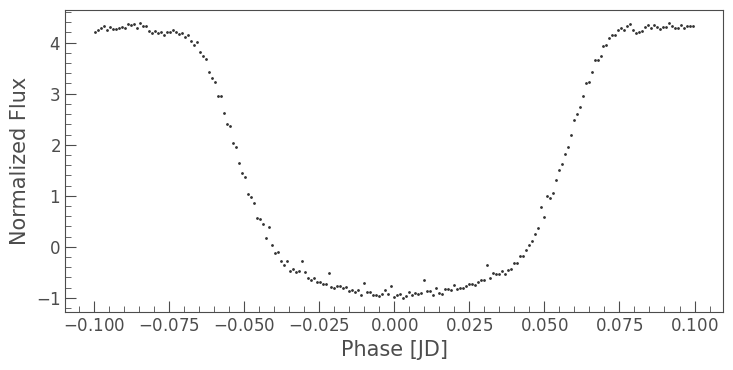

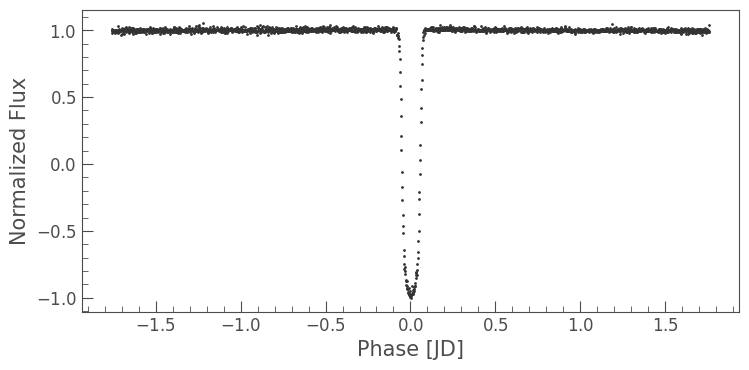

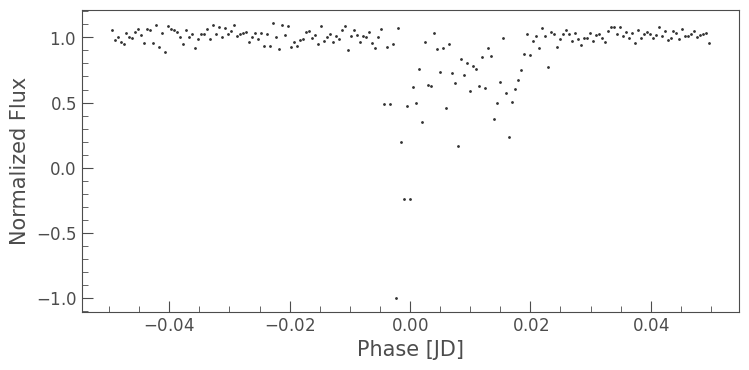

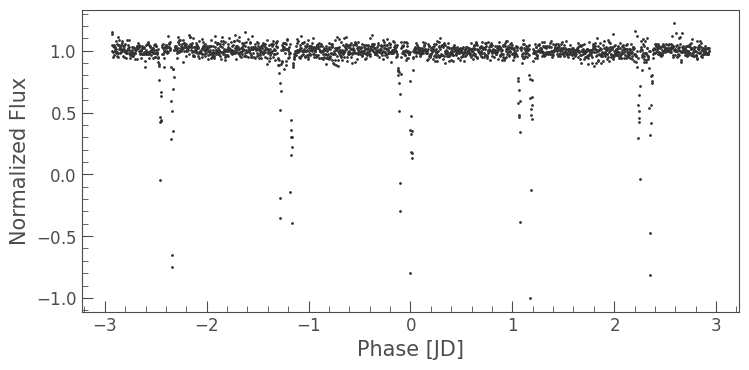

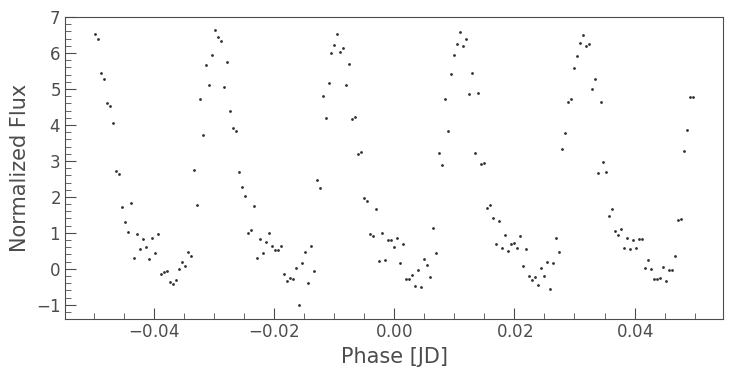

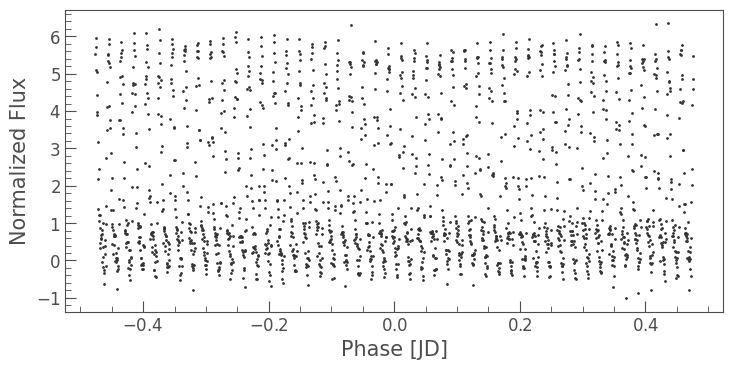

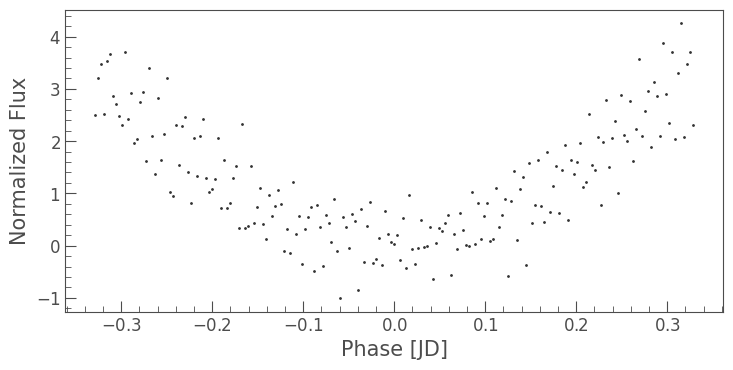

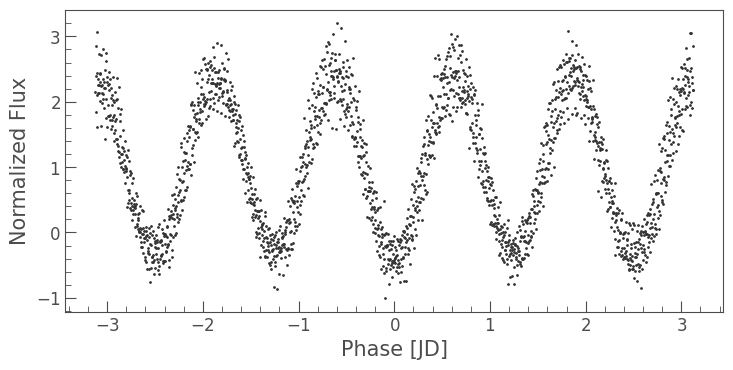

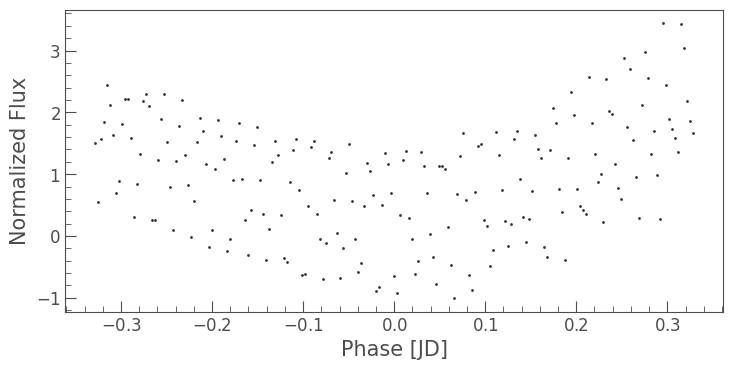

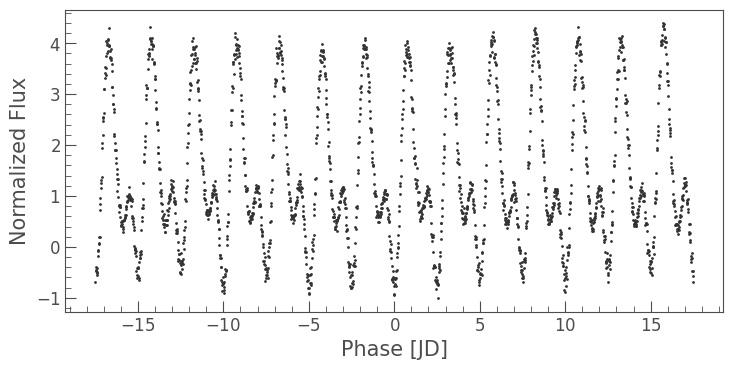

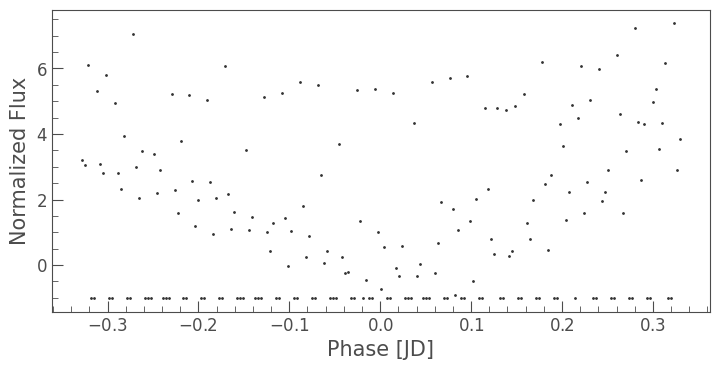

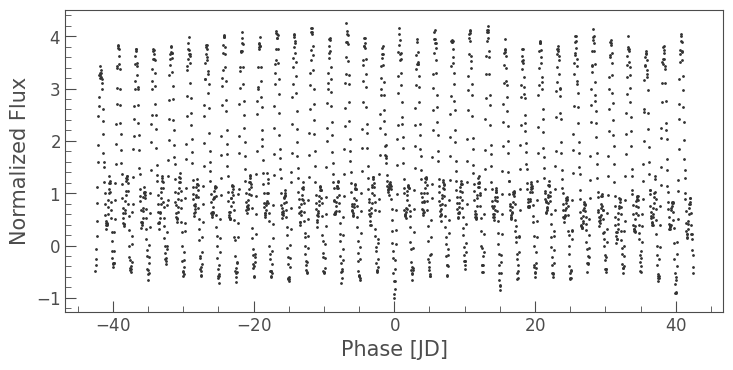

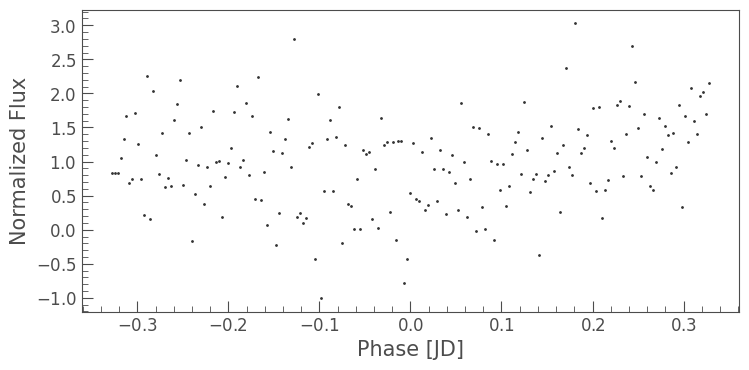

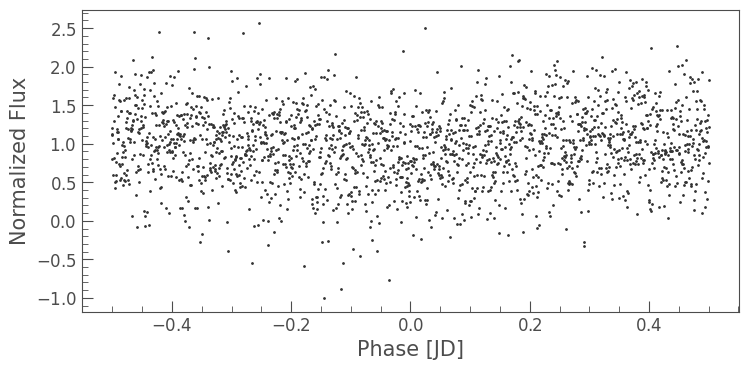

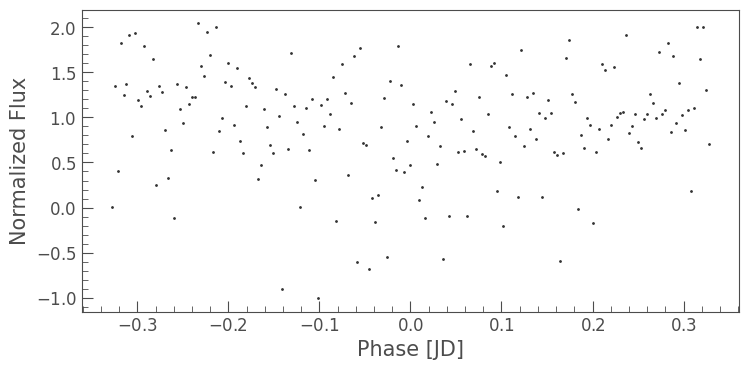

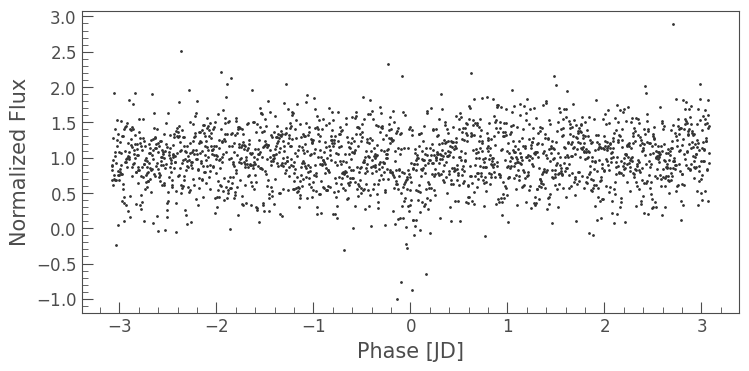

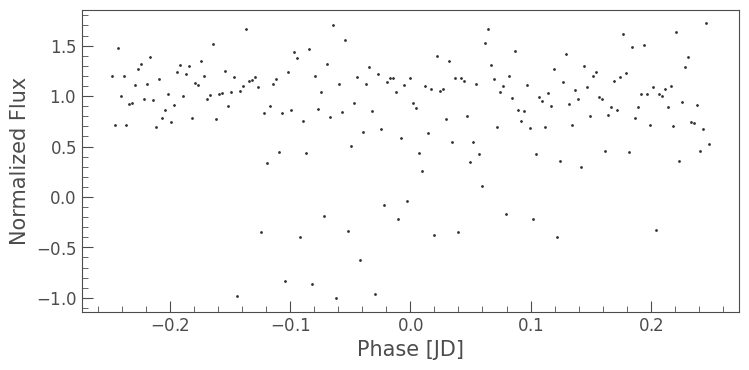

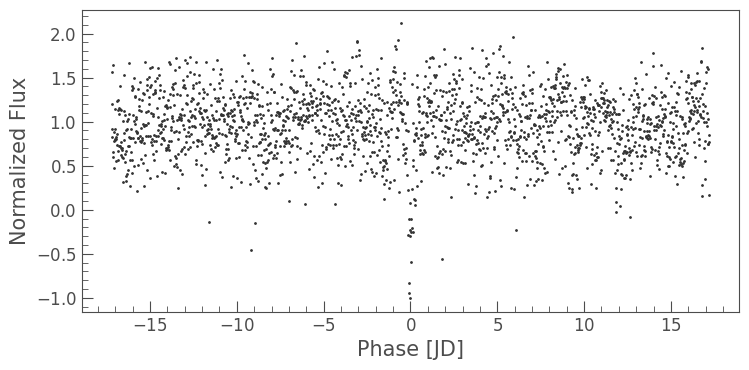

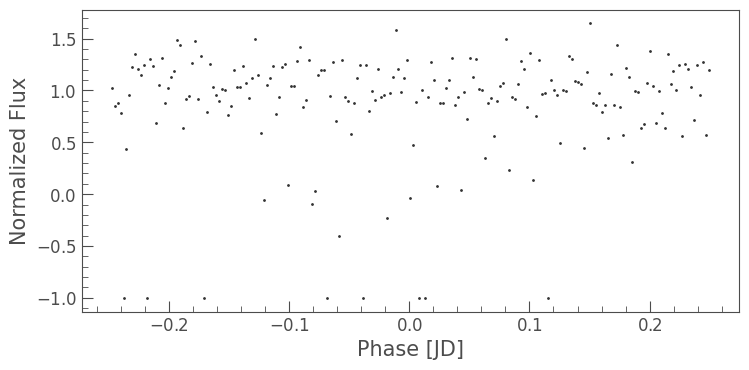

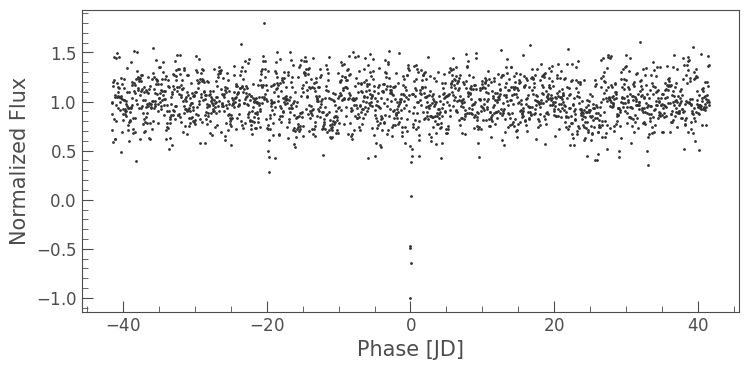

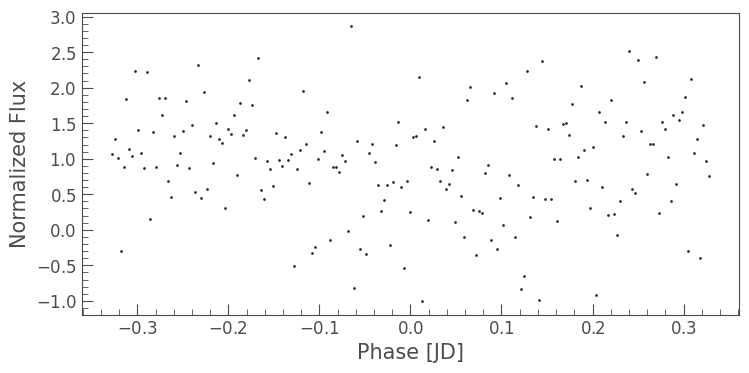

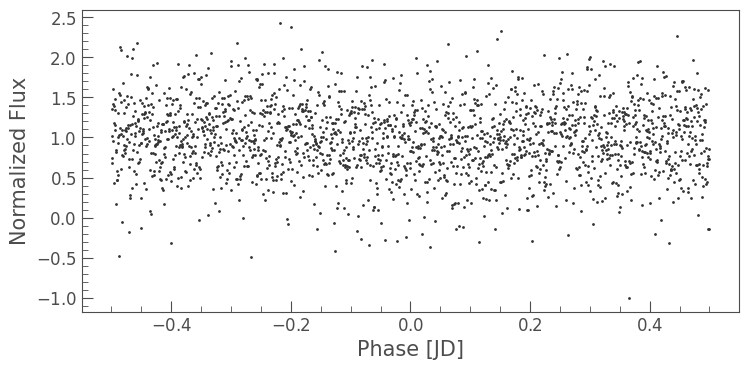

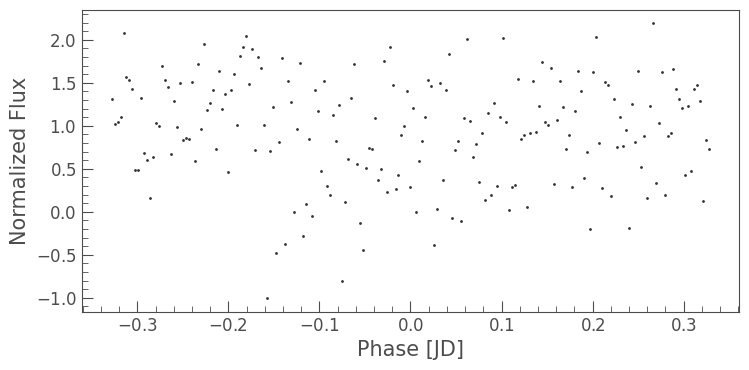

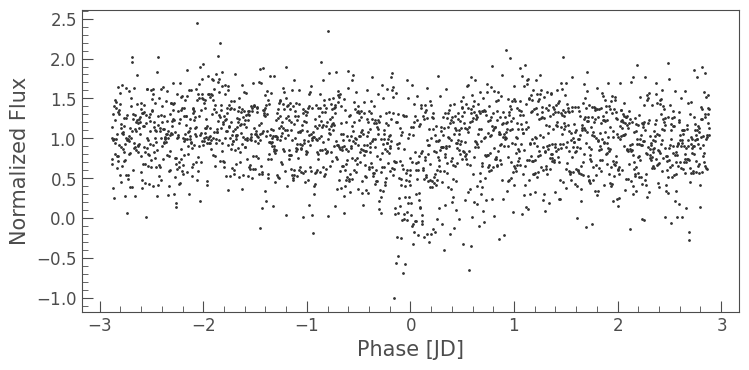

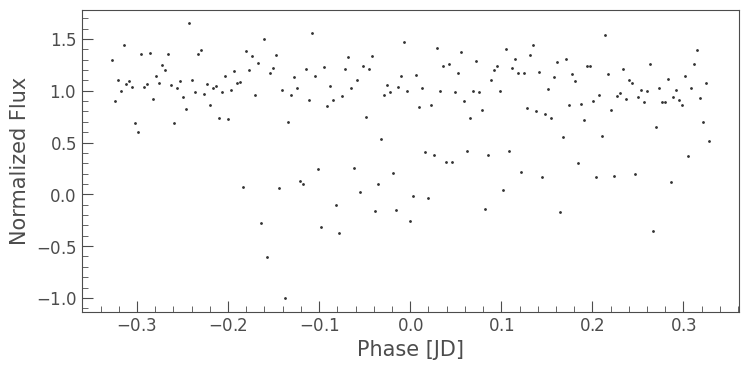

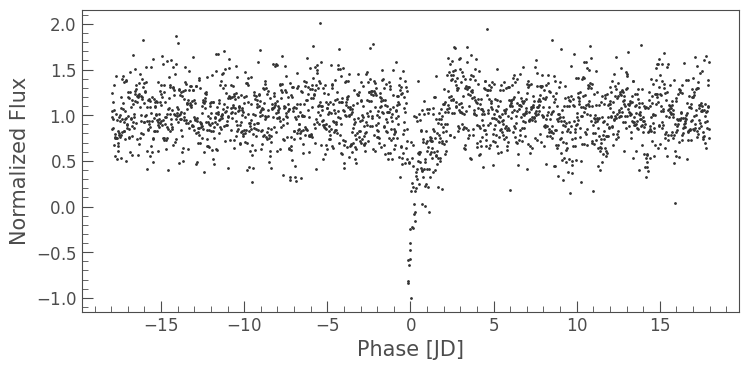

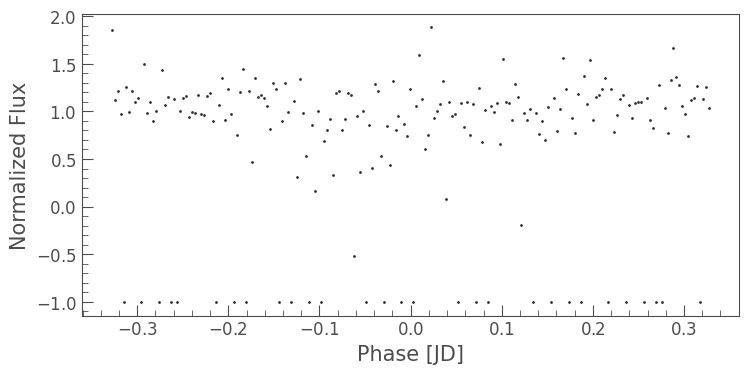

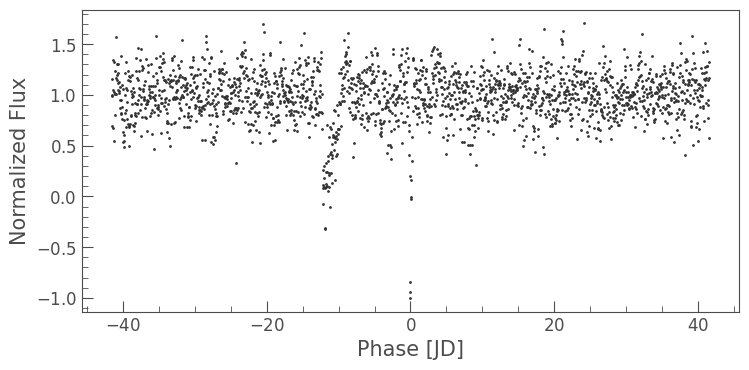

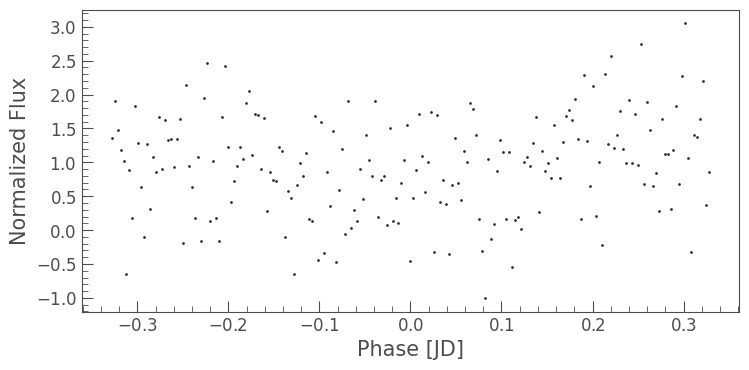

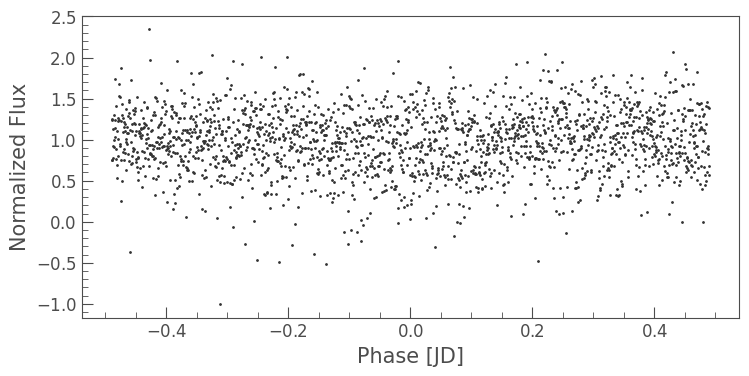

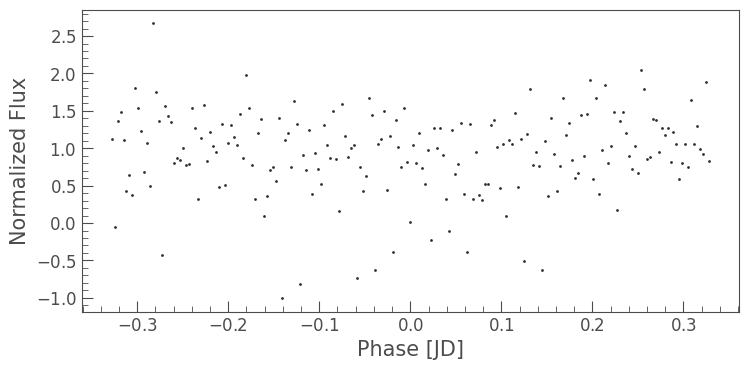

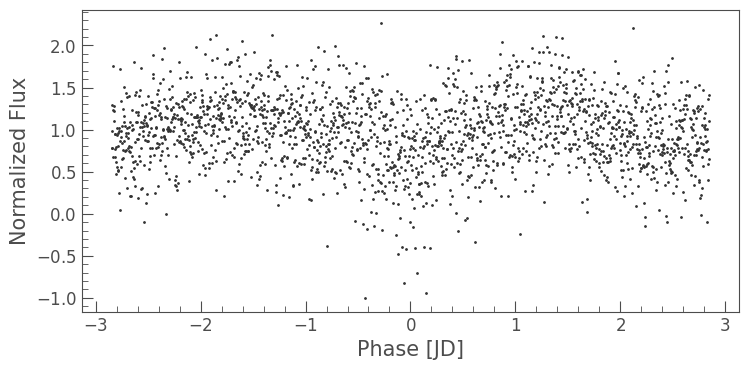

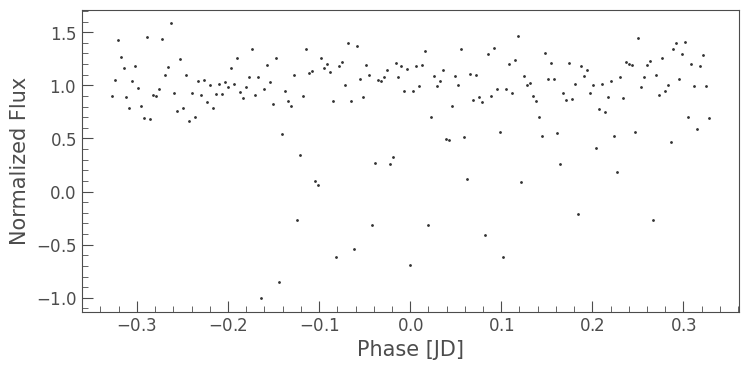

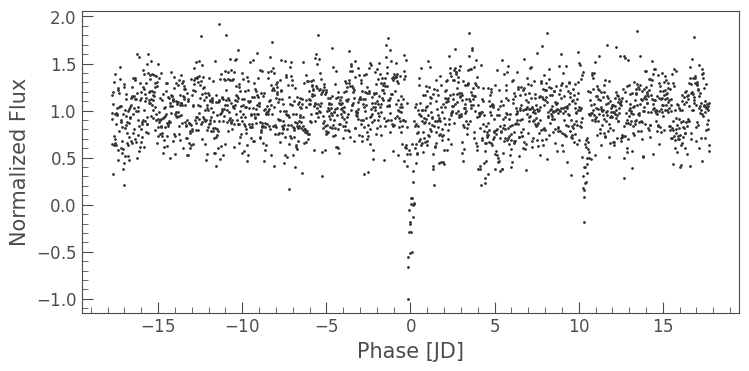

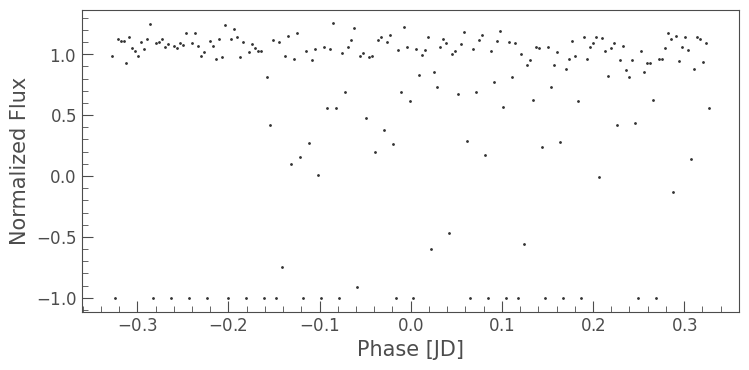

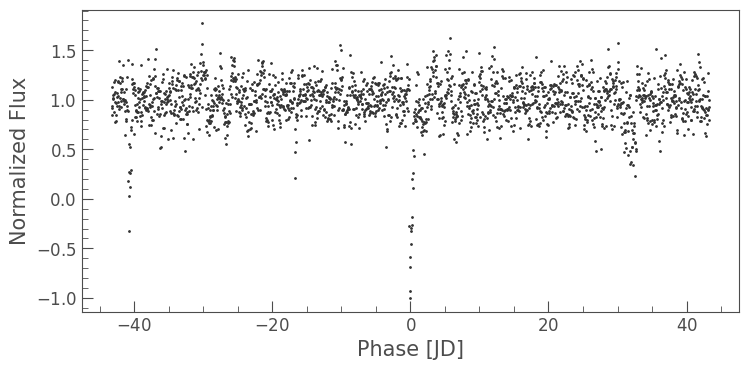

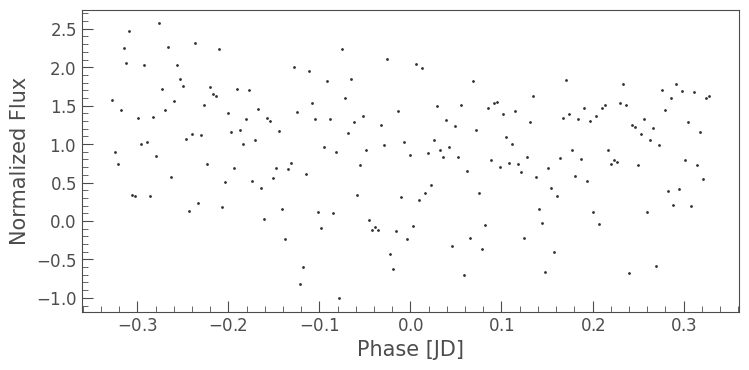

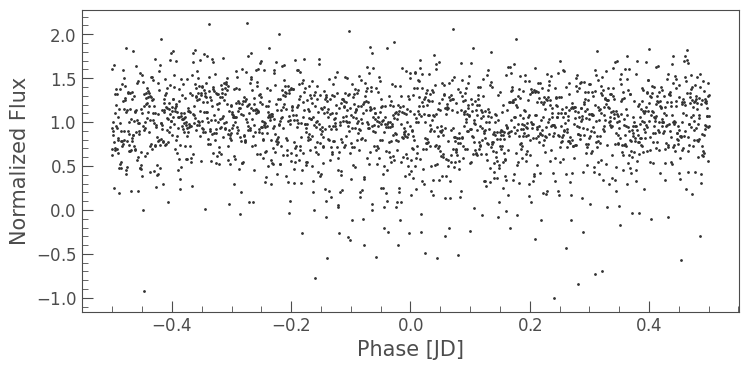

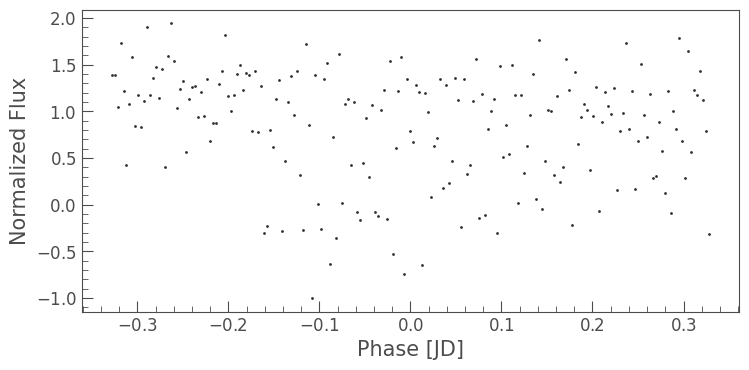

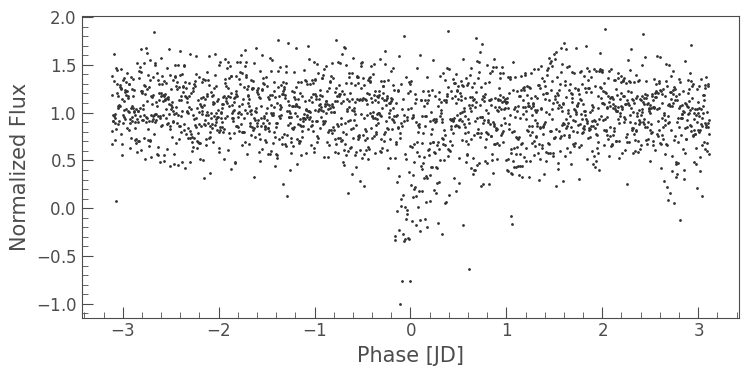

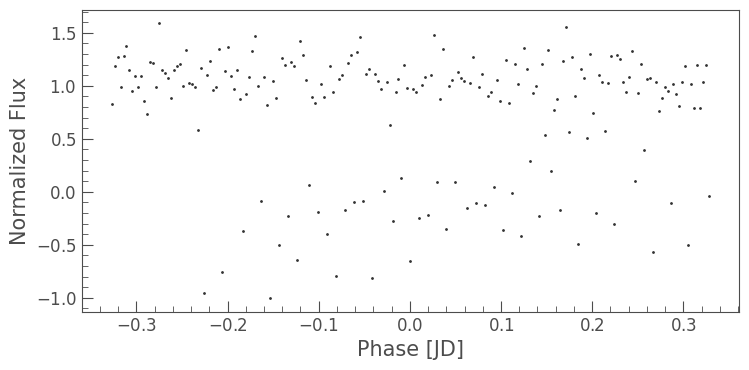

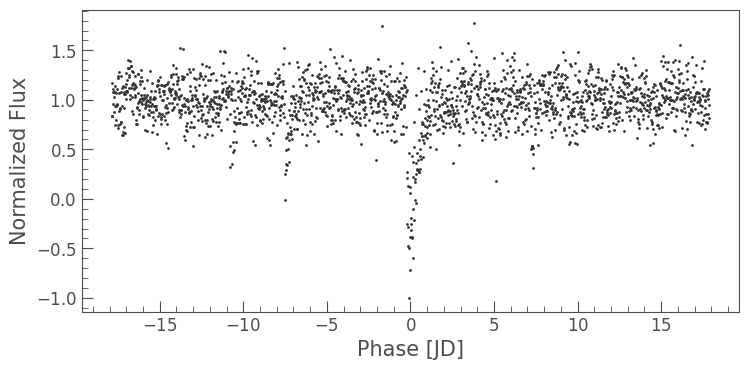

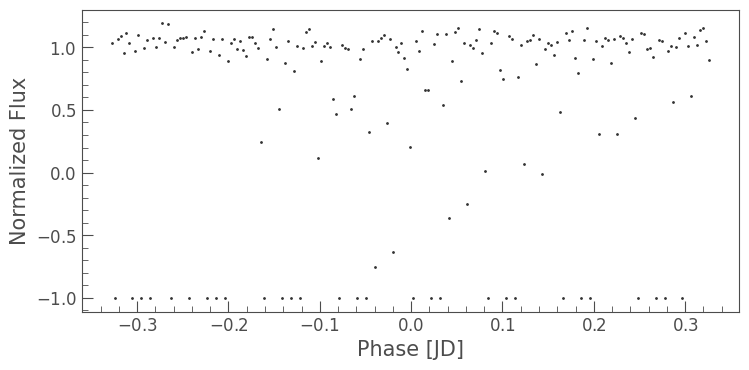

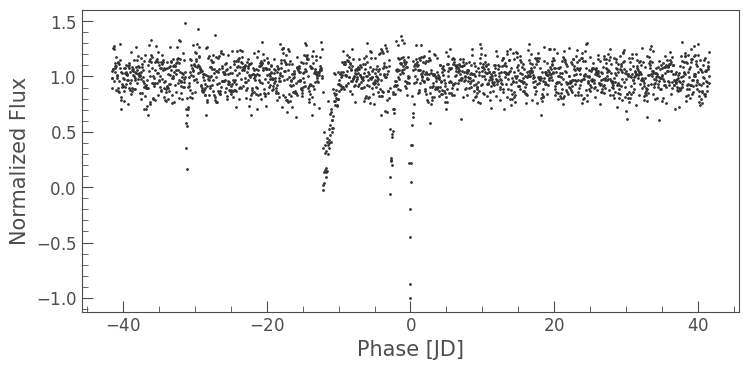

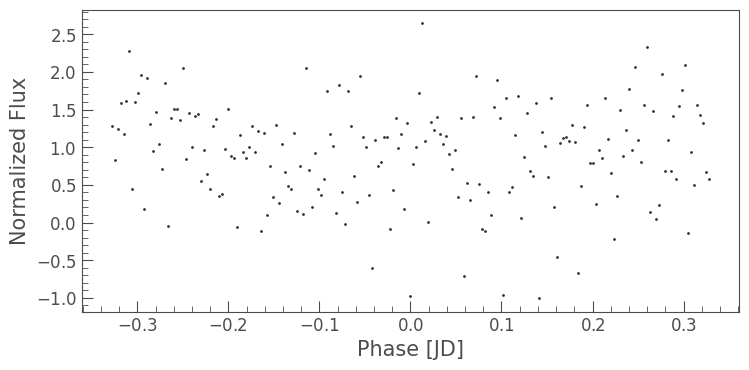

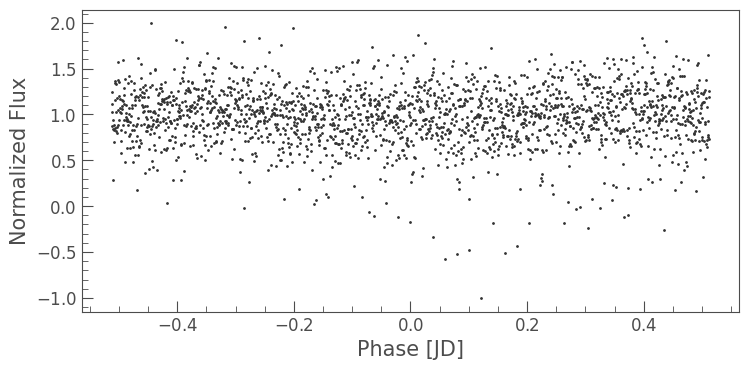

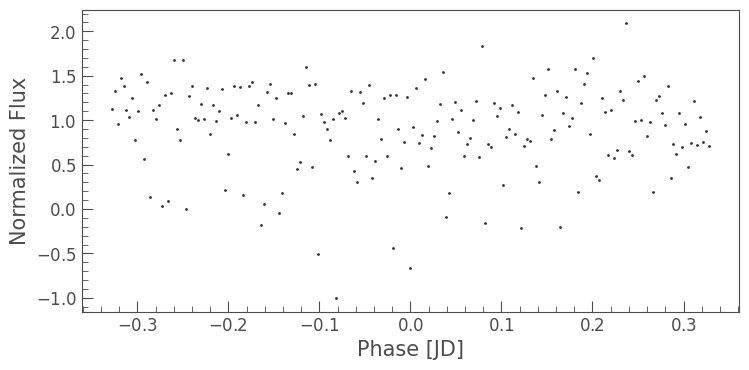

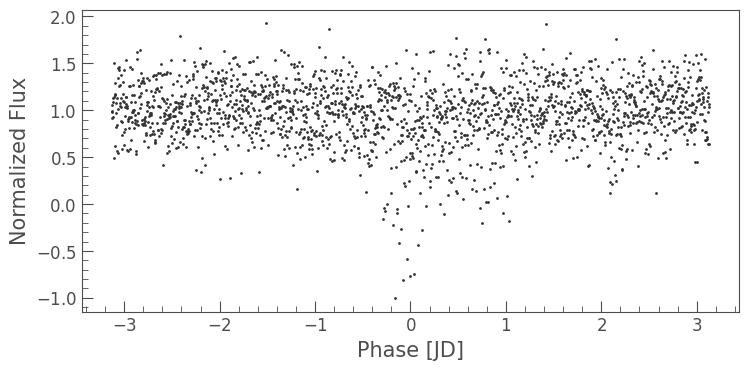

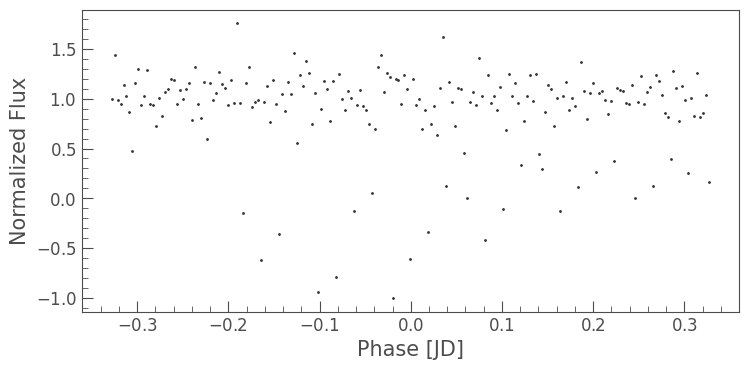

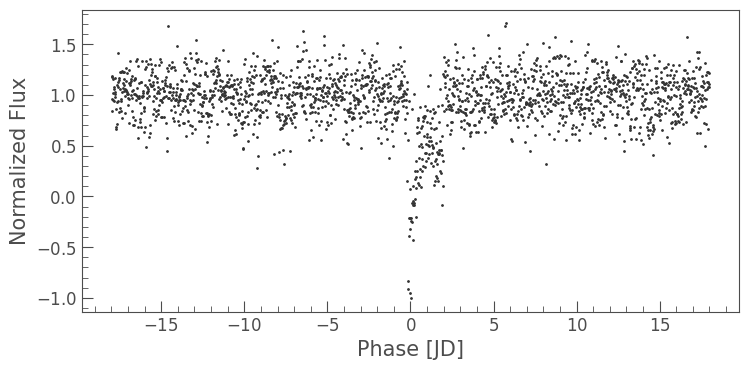

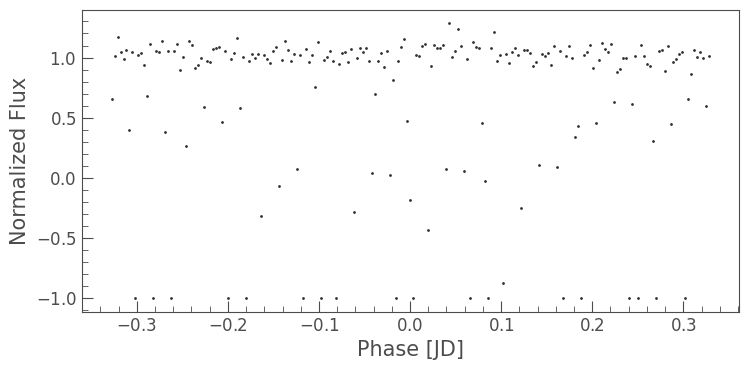

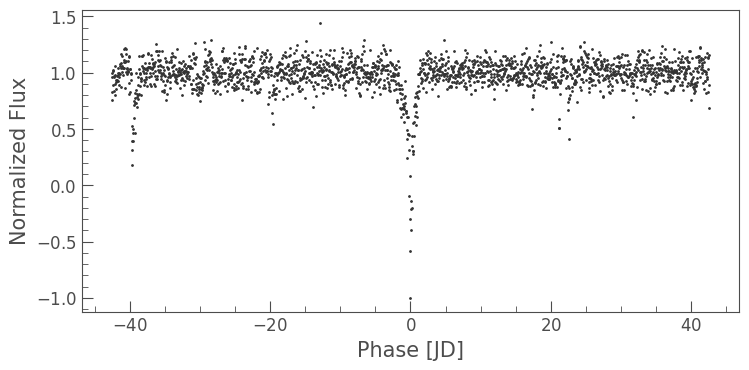

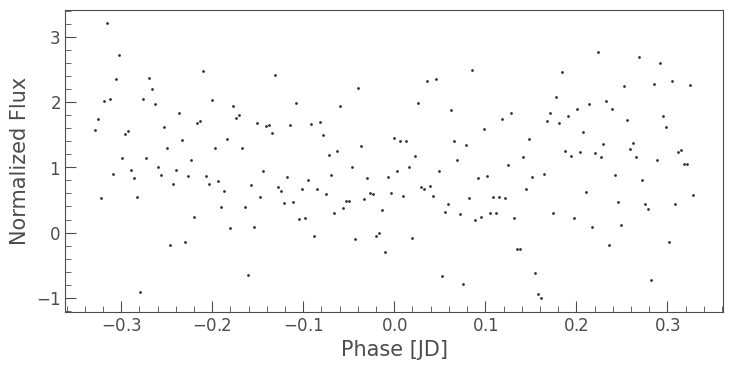

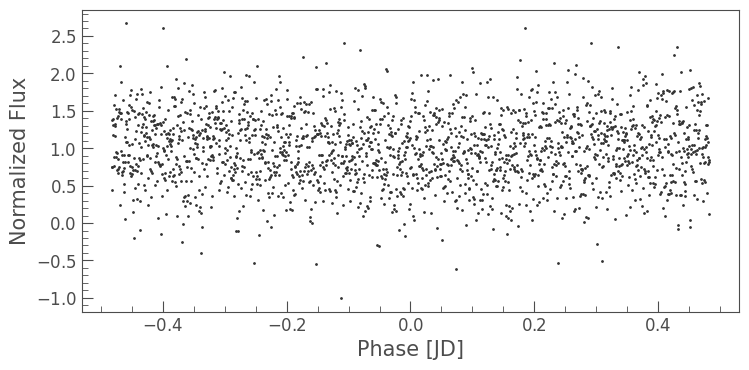

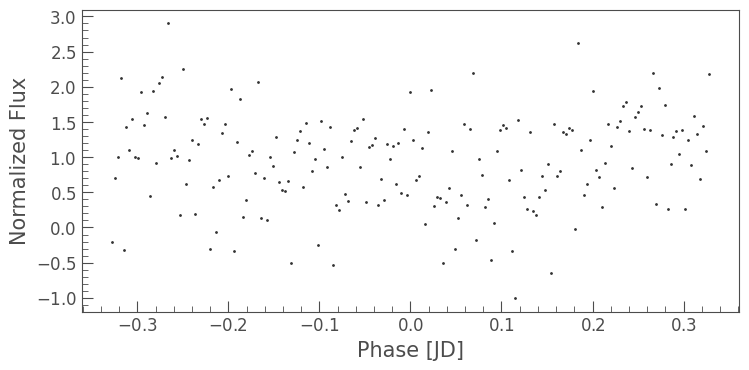

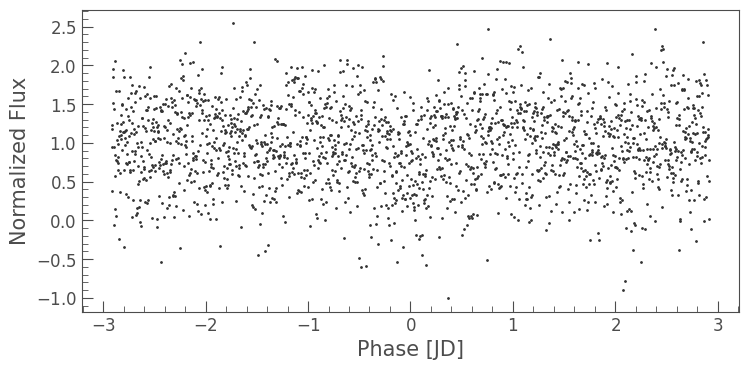

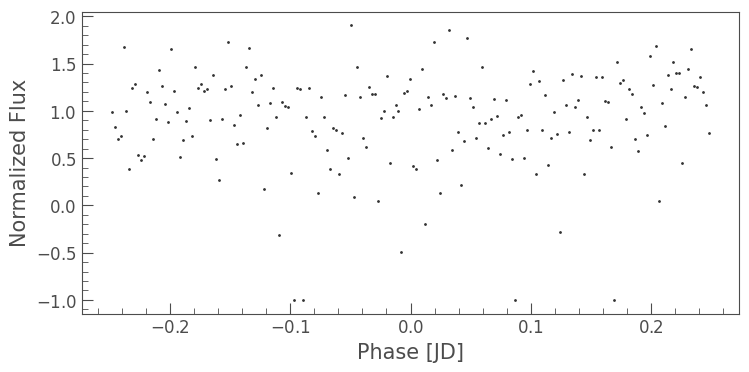

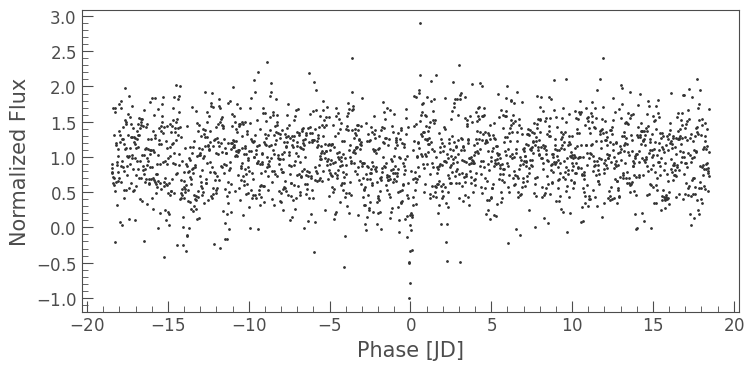

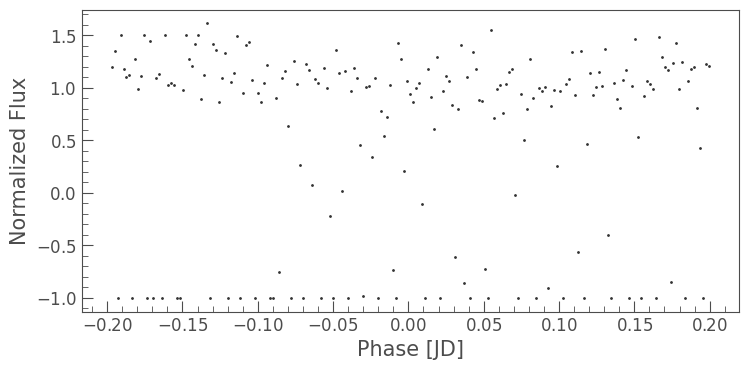

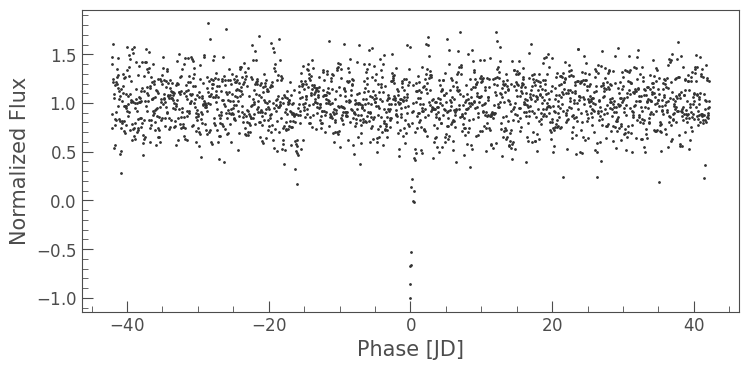

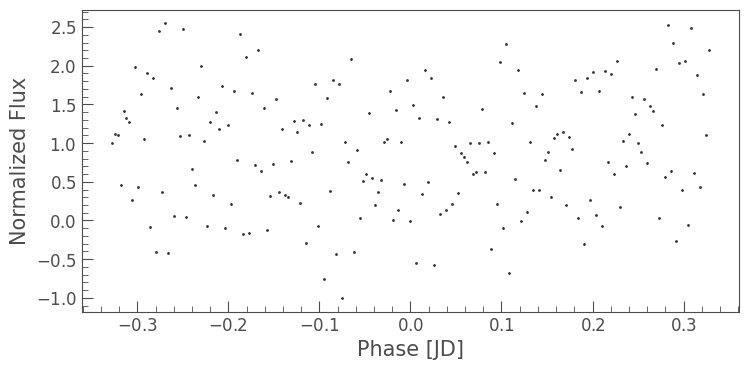

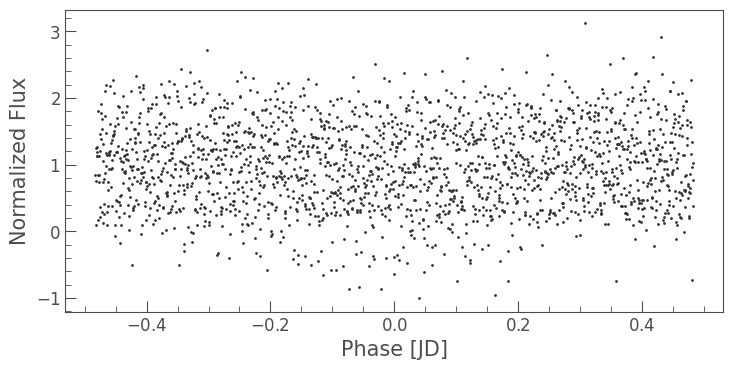

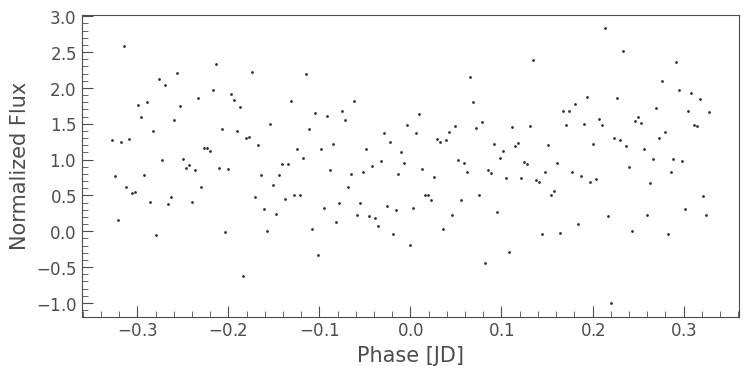

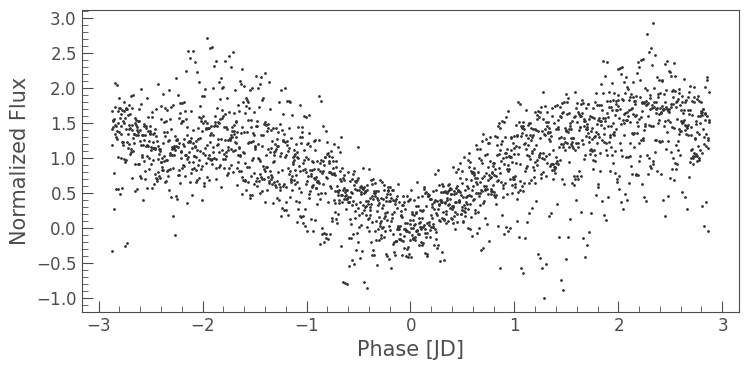

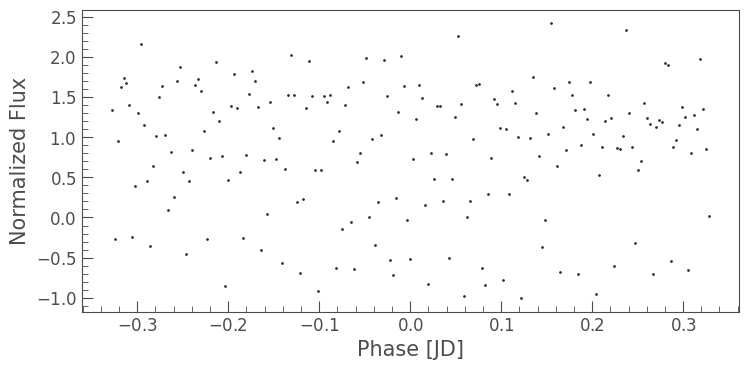

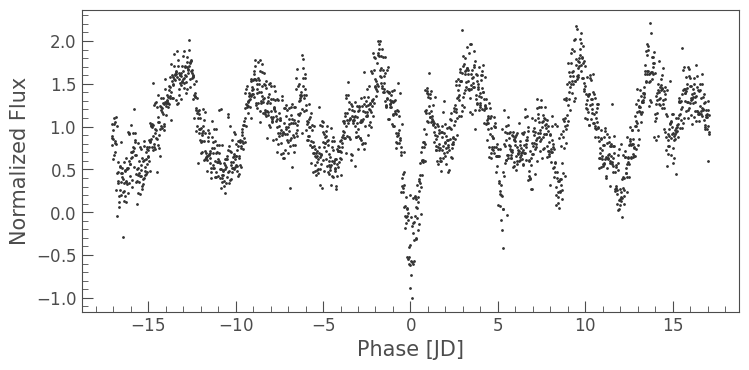

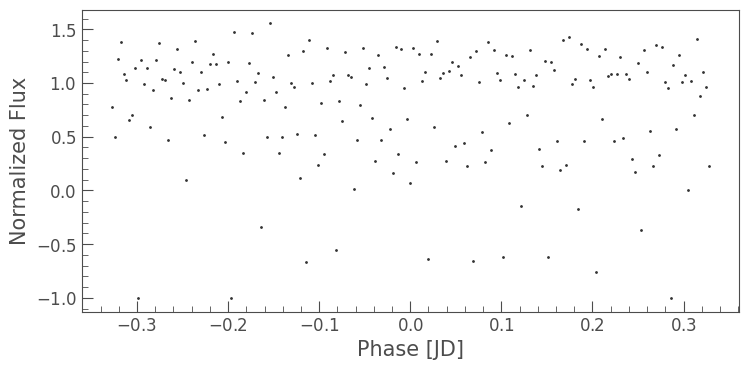

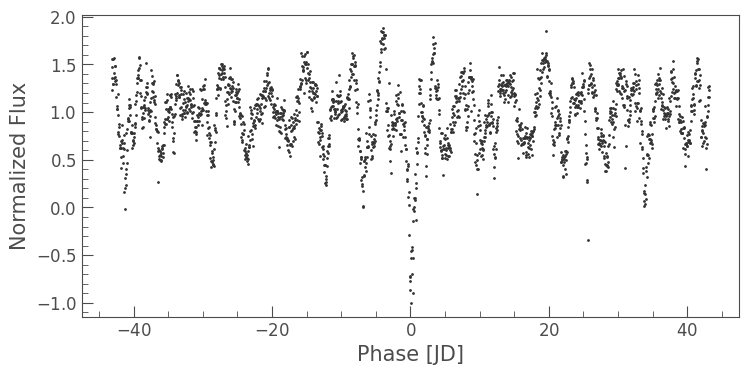

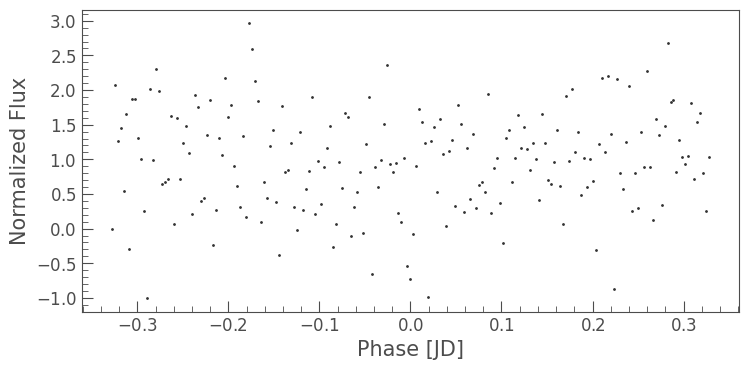

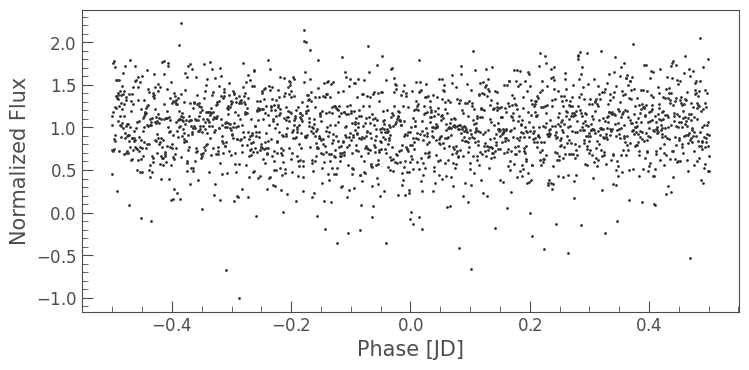

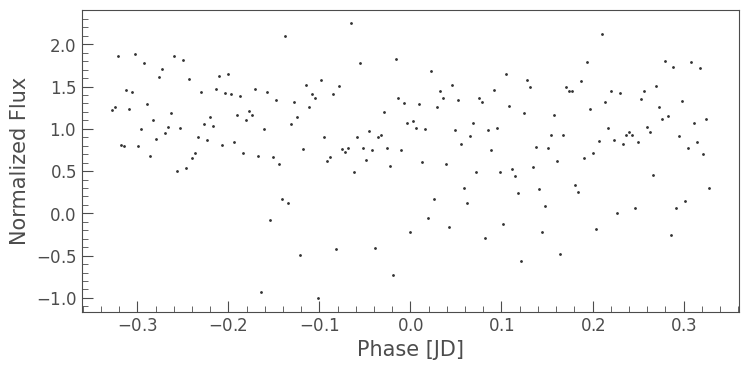

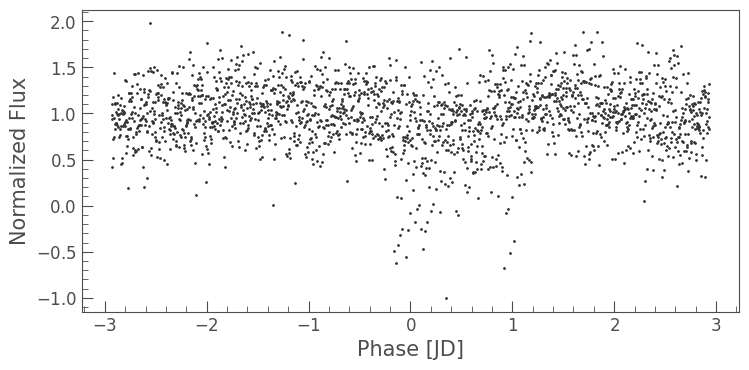

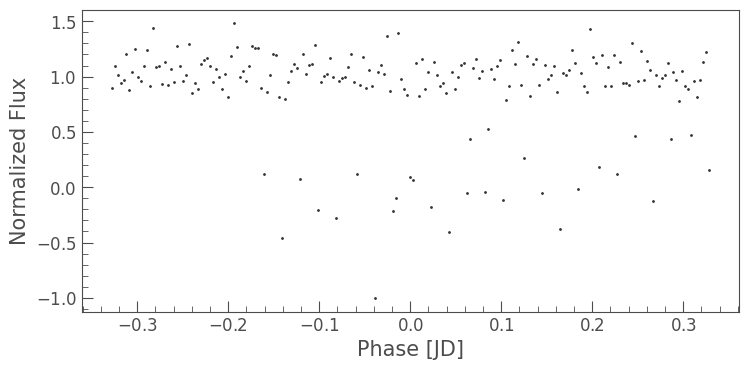

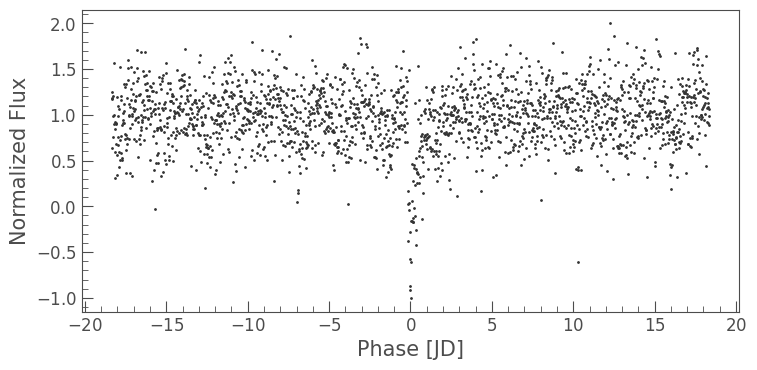

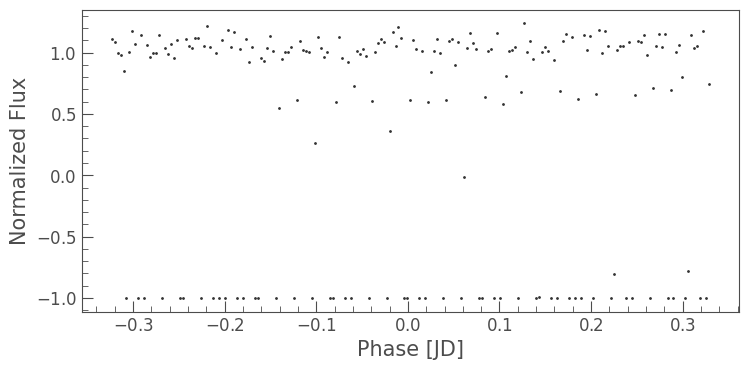

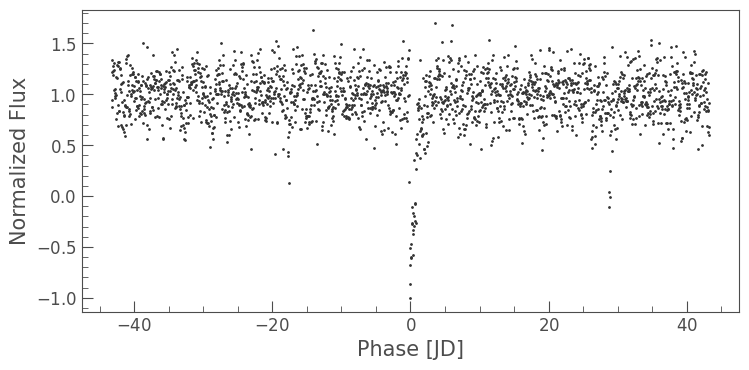

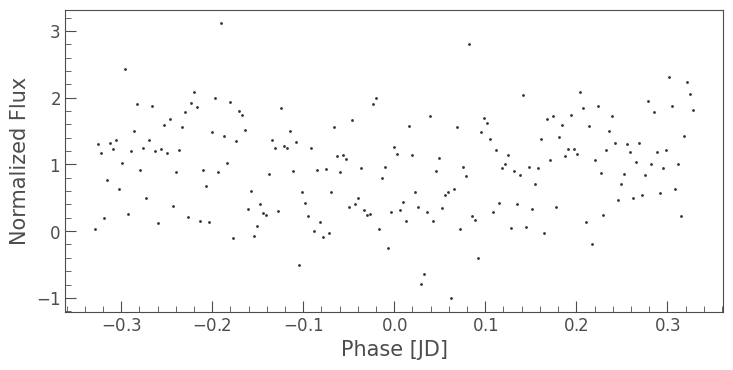

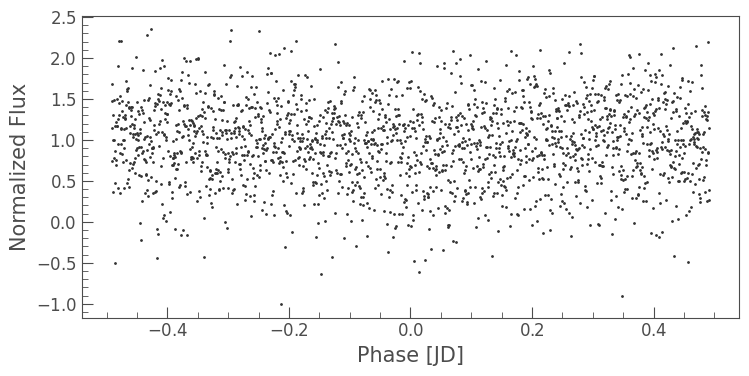

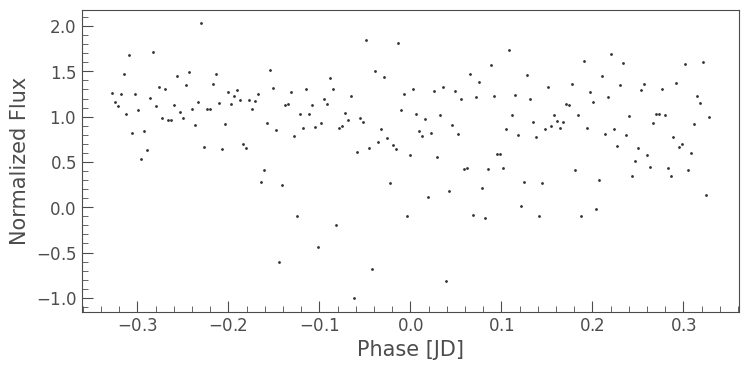

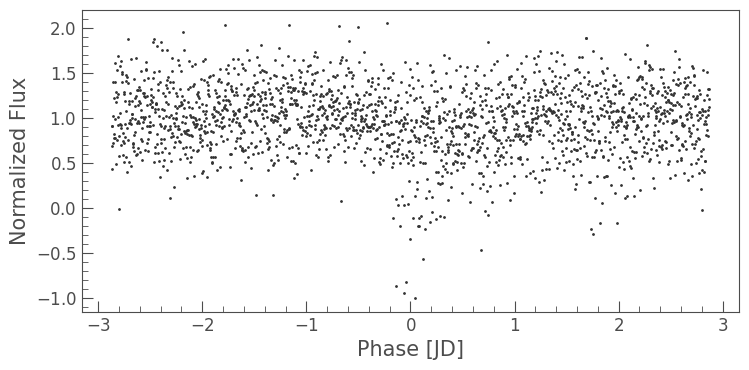

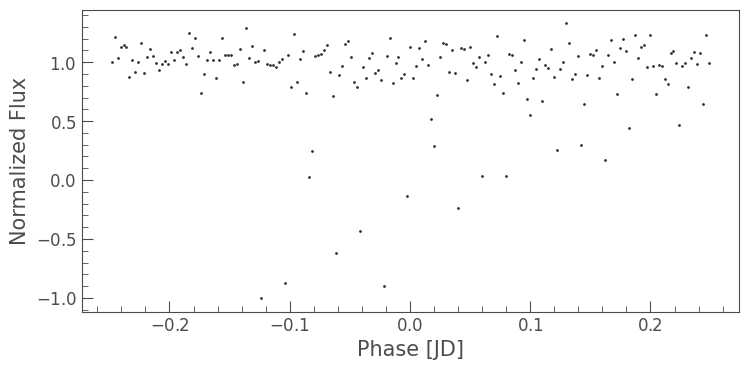

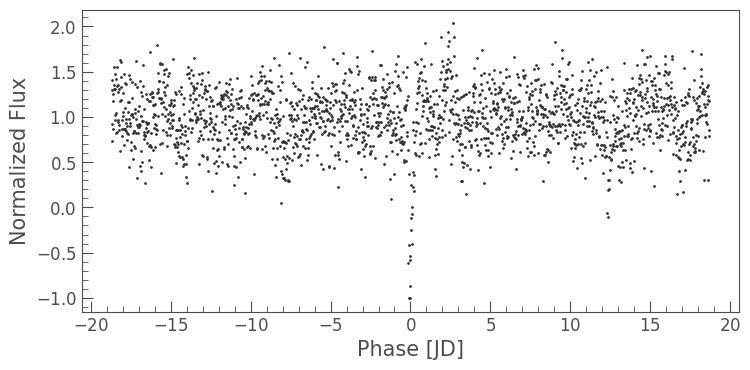

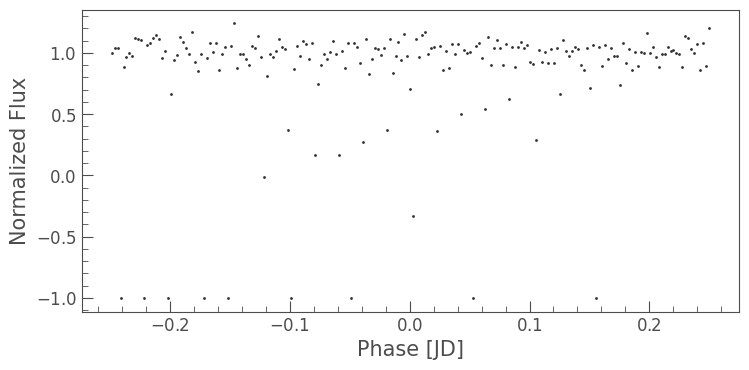

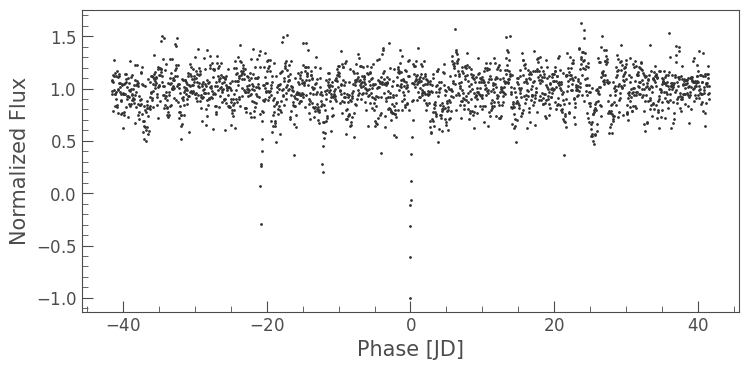

In [48]:
GV_SIZE = 2001
LV_SIZE = 201

lv_input, gv_input, output = np.zeros((n_views, LV_SIZE, 1)), np.zeros((n_views, GV_SIZE, 1)), np.zeros((n_views, 1))
i = 0

for item in grouped:
    lc = lcs[item["host"]]

    for period in item["periods"]:
        per = period["period"]
        delta = min(2, 0.05 * per)
        pdg = lc.to_periodogram("bls", period=np.linspace(max(0.5, per - delta), per + delta, 10000))
        per, dur, t0 = pdg.period_at_max_power, pdg.duration_at_max_power, pdg.transit_time_at_max_power
        fold = lc.fold(per, t0)

        gv = fold.bin(bins=GV_SIZE)

        if np.isnan(gv.flux.value).any():
            gv.flux.value[np.isnan(gv.flux.value)] = np.nanmin(gv.flux.value)
    
        gv = gv.normalize() - 1
        gv = (gv / np.abs(np.nanmin(gv.flux))) * 2.0 + 1
        
        fractional_duration = dur / per
        width = per.value * 1
        phase_mask = (fold.phase.value > -width * fractional_duration) & (fold.phase.value < width * fractional_duration)
        lc_zoom = fold[phase_mask]
        lv = lc_zoom.bin(bins=LV_SIZE)

        if np.isnan(lv.flux.value).any():
            lv.flux.value[np.isnan(lv.flux.value)] = np.nanmin(lv.flux.value)
    
        lv = lv.normalize() - 1
        lv = (lv / np.abs(np.nanmin(lv.flux))) * 2.0 + 1

        lv_input[i,:] = np.resize(lv.flux.value, lv_input[i].shape)
        gv_input[i,:] = np.resize(gv.flux.value, gv_input[i].shape)
        output[i,0] = period["planet"]

        if period["planet"]:
            mask = pdg.get_transit_mask(period=per, transit_time=t0, duration=dur)
            lc = lc[~mask]

        lv.scatter()
        gv.scatter()
        i += 1

# Neuronová sítě
## Formát vstupních dat

In [50]:
lv, gv, tg = np.copy(lv_input), np.copy(gv_input), np.copy(output)

n_lv, *lv_shape = lv.shape
n_gv, *gv_shape = gv.shape
n_targets, *target_shape = tg.shape

lv_shape, gv_shape, target_shape

([201, 1], [2001, 1], [1])

## Architektura

In [51]:
# LV branch.
lv_inp = Input(lv_shape)
lv_branch = Conv1D(16, (3), activation="relu")(lv_inp)
lv_branch = MaxPool1D()(lv_branch)
lv_branch = Conv1D(32, (3), activation="relu")(lv_branch)
lv_branch = MaxPool1D()(lv_branch)
lv_branch = Conv1D(64, (3), activation="relu")(lv_branch)
lv_branch = MaxPool1D()(lv_branch)
lv_branch = Flatten()(lv_branch)
lv_branch = Model(lv_inp, lv_branch)

# GV branch.
gv_inp = Input(gv_shape)
gv_branch = Conv1D(16, (3), activation="relu")(gv_inp)
gv_branch = MaxPool1D()(gv_branch)
gv_branch = Conv1D(32, (3), activation="relu")(gv_branch)
gv_branch = MaxPool1D()(gv_branch)
gv_branch = Conv1D(64, (3), activation="relu")(gv_branch)
gv_branch = MaxPool1D()(gv_branch)
gv_branch = Flatten()(gv_branch)
gv_branch = Model(gv_inp, gv_branch)

# Main branch.
main_branch = Concatenate()([lv_branch.output, gv_branch.output])
main_branch = Dense(128, activation="tanh")(main_branch)
main_branch = Dense(128, activation="tanh")(main_branch)
main_branch = Dense(1, activation="tanh")(main_branch)
model = Model([lv_branch.input, gv_branch.input], main_branch)

model.compile(optimizer=RMSprop(), loss="mse")

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 201, 1)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 199, 16)      64          input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 1999, 16)     64          input_10[0][0]                   
___________________________________________________________________________________________

## Trénovací a testovací množina

In [53]:
def shuffle(*args, seed=None):
    i = np.arange(args[0].shape[0])
    np.random.seed(seed)
    np.random.shuffle(i)
    return tuple(map(lambda x: x[i], args))

test_size = 2
#lv, gv, tg = shuffle(lv, gv, tg)

train_gv, test_gv = gv[:-test_size + 1], gv[-test_size + 1:]
train_lv, test_lv = lv[:-test_size + 1], lv[-test_size + 1:]
train_tg, test_tg = tg[:-test_size + 1], tg[-test_size + 1:]

train_gv, test_gv = gv[:], gv[:]
train_lv, test_lv = lv[:], lv[:]
train_tg, test_tg = tg[:], tg[:]

lv.shape, gv.shape, tg.shape
train_lv.shape, test_lv.shape, train_gv.shape, train_lv.shape

((92, 201, 1), (92, 201, 1), (92, 2001, 1), (92, 201, 1))

## Trénování

In [55]:
callback = EarlyStopping(monitor="loss", patience=50)
model.fit([train_lv, train_gv], train_tg, epochs=10000, validation_split=0.15, callbacks=[callback])

Epoch 1/10000
3/3 [==============================] - 0s 95ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 2/10000
3/3 [==============================] - 0s 65ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 3/10000
3/3 [==============================] - 0s 107ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 4/10000
3/3 [==============================] - 0s 72ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 5/10000
3/3 [==============================] - 0s 72ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 6/10000
3/3 [==============================] - 0s 71ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 7/10000
3/3 [==============================] - 0s 76ms/step - loss: 2.0000 - val_loss: 1.0000
Epoch 8/10000
3/3 [==============================] - 0s 84ms/step - loss: 1.9999 - val_loss: 0.9999
Epoch 9/10000
3/3 [==============================] - 0s 86ms/step - loss: 1.9998 - val_loss: 0.9974
Epoch 10/10000
3/3 [==============================] - 0s 77ms/step - loss: 1.5958 - val_loss: 0.953

## Testování

In [56]:
results = np.abs(np.round(model.predict([test_lv, test_gv])))
errors = (results != test_tg).sum()
percentage = 100 - 100 * np.round(errors / len(test_lv), 2)

f"Errors: {errors} (success rate: {percentage} %)"

'Errors: 0 (success rate: 100.0 %)'

In [57]:
model.save("transit_nn.h5")